### Supervised Learning - Boosting

*Nikola Savic at gmail dot com*

## Imports

In [31]:
import time

import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = [7, 7]

from sklearn.datasets import fetch_openml

from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import learning_curve
from sklearn.model_selection import validation_curve
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score
from sklearn.metrics import plot_precision_recall_curve
from sklearn.metrics import classification_report
from sklearn.metrics import plot_confusion_matrix

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier

## Fetch, Split and Standardize Data

In [3]:
random_state = 2020

X_cred, y_cred = fetch_openml("credit-g", return_X_y=True)
X_mnist, y_mnist = fetch_openml('mnist_784', version=1, return_X_y=True)

X_cred = pd.DataFrame(X_cred)
y_cred = pd.DataFrame(y_cred)

X_mnist = pd.DataFrame(X_mnist)
y_mnist = pd.DataFrame(y_mnist)

# mapped_back_to_string_label = mapping.take(results)
y_cred[0], cred_mapping = pd.factorize(y_cred[0])
y_mnist[0], mnist_mapping = pd.factorize(y_mnist[0], sort=True)

# Create holdout test set
X_cred_train, X_cred_test, y_cred_train, y_cred_test = train_test_split(X_cred, y_cred, test_size=0.2,
                                                                        random_state=random_state,
                                                                        stratify=y_cred)

X_mnist_train, X_mnist_test, y_mnist_train, y_mnist_test = train_test_split(X_mnist, y_mnist, test_size=0.2,
                                                                            random_state=random_state,
                                                                            stratify=y_mnist)

def get_data(data):
    return data["X"], data["y"], data["name"]

# Standardize
scaler_cred = StandardScaler()
scaler_cred.fit(X_cred_train)
X_cred_train = pd.DataFrame(scaler_cred.transform(X_cred_train), index=y_cred_train.index)
X_cred_test = pd.DataFrame(scaler_cred.transform(X_cred_test), index=y_cred_test.index)

X_mnist_train = pd.DataFrame(X_mnist_train / 255.0, index=y_mnist_train.index)
X_mnist_test = pd.DataFrame(X_mnist_test / 255.0, index=y_mnist_test.index)

# Create data sets
cred = {"X": X_cred_train, "y": y_cred_train, "name": "Credit Train"}
cred_test = {"X": X_cred_test, "y": y_cred_test, "name": "Credit Test"}

mnist = {"X": X_mnist_train, "y": y_mnist_train, "name": "MNIST Train"}
mnist_test = {"X": X_mnist_test, "y": y_mnist_test, "name": "MNIST Test"}


## Shared Functions

In [4]:
def print_cross_val(clf, data_set, cv=5, v=1):
    print(clf)
    X, y, name = get_data(data_set)
    scores = cross_val_score(clf, X, y, cv=cv, scoring='accuracy', verbose=v, n_jobs=-1)
    time.sleep(1)
    print("{} : {}".format(clf.__class__.__name__, name))
    print("Scores: ", scores, "Avg: ", np.mean(scores))

In [37]:
def build_confusion_matrix(clf, data_set):
    print(clf)
    X, y, name = get_data(data_set)
    title = "{} : {}".format(clf.__class__.__name__, name)
    disp = plot_confusion_matrix(clf, X, y, normalize="true", cmap=plt.cm.Blues)
    disp.ax_.set_title(title)

In [6]:
def build_learning_curve(clf, data_set, scoring="accuracy", axes=None, ylim=None, cv=5, n_jobs=-1, train_sizes=np.linspace(.1, 1.0, 5)):
    print(clf)
    X, y, name = get_data(data_set)
    title = "{} : {}".format(clf.__class__.__name__, name)
    
    if axes is None:
        _, axes = plt.subplots(1, 3, figsize=(30, 10))

    axes[0].set_title(title)
    if ylim is not None:
        axes[0].set_ylim(*ylim)
    axes[0].set_xlabel("Training examples")
    axes[0].set_ylabel(scoring)

    train_sizes, train_scores, test_scores, fit_times, _ = learning_curve(
        clf, X, y, cv=cv, n_jobs=n_jobs, scoring=scoring, train_sizes=train_sizes, return_times=True, random_state=random_state
    )
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    fit_times_mean = np.mean(fit_times, axis=1)
    fit_times_std = np.std(fit_times, axis=1)

    # Plot learning curve
    axes[0].grid()
    axes[0].fill_between(train_sizes, train_scores_mean - train_scores_std,
                         train_scores_mean + train_scores_std, alpha=0.1,
                         color="r")
    axes[0].fill_between(train_sizes, test_scores_mean - test_scores_std,
                         test_scores_mean + test_scores_std, alpha=0.1,
                         color="g")
    axes[0].plot(train_sizes, train_scores_mean, 'o-', color="r",
                 label="Training score")
    axes[0].plot(train_sizes, test_scores_mean, 'o-', color="g",
                 label="Cross-validation score")
    axes[0].legend(loc="best")

    # Plot n_samples vs fit_times
    axes[1].grid()
    axes[1].plot(train_sizes, fit_times_mean, 'o-')
    axes[1].fill_between(train_sizes, fit_times_mean - fit_times_std,
                         fit_times_mean + fit_times_std, alpha=0.1)
    axes[1].set_xlabel("Training examples")
    axes[1].set_ylabel("fit_times")
    axes[1].set_title("Scalability of the model")

    # Plot fit_time vs score
    axes[2].grid()
    axes[2].plot(fit_times_mean, test_scores_mean, 'o-')
    axes[2].fill_between(fit_times_mean, test_scores_mean - test_scores_std,
                         test_scores_mean + test_scores_std, alpha=0.1)
    axes[2].set_xlabel("fit_times")
    axes[2].set_ylabel(scoring)
    axes[2].set_title("Performance of the model")
    plt.show()

In [21]:
def build_validation_curve(clf, data_set, param_name, param_range, scoring="accuracy", cv=5):
    print(clf)
    X, y, name = get_data(data_set)
    
    train_scores, test_scores = validation_curve(
        clf, X, y, param_name=param_name, param_range=param_range, scoring=scoring, cv=cv, n_jobs=-1
    )
    
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    train_scores_max = np.max(train_scores_mean)
    train_scores_max_idx = np.argmax(train_scores_mean)
    train_scores_max_x = param_range[train_scores_max_idx]
    
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    test_scores_max = np.max(test_scores_mean)
    test_scores_max_idx = np.argmax(test_scores_mean)
    test_scores_max_x = param_range[test_scores_max_idx]

    plt.title("Validation Curve with " + clf.__class__.__name__ + " : " + name)
    plt.xlabel(param_name)
    plt.ylabel(scoring)
    plt.ylim(0.0, 1.1)
    lw = 2
    
    plt.plot(param_range, train_scores_mean, label="Training score", color="darkorange", lw=lw,
              marker="x",markeredgewidth=3, ms=8, markevery=[train_scores_max_idx])

    plt.fill_between(param_range, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1, color="darkorange", lw=lw)

#     plt.semilogx(param_range, test_scores_mean, label="Cross-validation score", color="navy", lw=lw)
    plt.plot(param_range, test_scores_mean, label="Test score", color="navy", lw=lw,
             marker="x", markeredgewidth=3, ms=8, markevery=[test_scores_max_idx])

    plt.fill_between(param_range, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="navy", lw=lw)
    
    # Plot a dotted vertical line at the best score for that scorer marked by x
    plt.axvline(x=train_scores_max_x, linestyle="--", color="darkorange")
    plt.annotate("Train %0.2f" % train_scores_max, (train_scores_max_x, train_scores_max + 0.05))
   
    plt.axvline(x=test_scores_max_x, linestyle="--", color="navy")
    plt.annotate("Test %0.2f" % test_scores_max, (test_scores_max_x, test_scores_max - 0.05))

    plt.legend(loc="best")
    plt.show()

In [8]:
def print_gridsearch(data_set, parameters = {"random_state": random_state}, tuned_parameters={}, scores=["accuracy"]):
    X, y, name = get_data(data_set)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=random_state)

    best = []
    for score in scores:
        print("# Tuning hyper-parameters for %s" % score)
        print()

        clf = GridSearchCV(DecisionTreeClassifier(**parameters), tuned_parameters, scoring=score, n_jobs=-1)
        clf.fit(X_train, y_train)

        print("Best parameters set found on development set:")
        print()
        print(clf.best_params_)
        best.append((clf.best_score_, clf.best_params_, clf.best_estimator_))
        print()
        print("Grid scores on development set:")
        print()
        means = clf.cv_results_['mean_test_score']
        stds = clf.cv_results_['std_test_score']
        for mean, std, params in zip(means, stds, clf.cv_results_['params']):
            print("%0.3f (+/-%0.03f) for %r" % (mean, std * 2, params))
        print()

        print("Detailed classification report:")
        print()
        print("The model is trained on the full development set.")
        print("The scores are computed on the full evaluation set.")
        print()
        y_true, y_pred = y_test, clf.predict(X_test)
        print(classification_report(y_true, y_pred))
        print()

    print("Best parameters")
    for i in range(len(best)):
        print(scores[i])
        print(best[i])

In [98]:
def build_cred_precision_recall_curve(clf, data_set):
    print(clf)
    X, y, name = get_data(data_set)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.5, random_state=random_state)
    
    clf.fit(X_train, y_train)
    y_score = clf.predict(X_test)

    disp = plot_precision_recall_curve(clf, X_test, y_test)
    disp.ax_.set_title('{0} Precision-Recall curve'.format(name))

## Training: cross_val scores (accuracy)

In [46]:
n_estimators = 100
max_depth = 3
splitter = "random"
mada = AdaBoostClassifier(DecisionTreeClassifier(max_depth=max_depth,
                                                 splitter=splitter),
                          n_estimators=n_estimators,
                          random_state=random_state)
print_cross_val(mada, mnist)

AdaBoostClassifier(algorithm='SAMME.R',
                   base_estimator=DecisionTreeClassifier(ccp_alpha=0.0,
                                                         class_weight=None,
                                                         criterion='gini',
                                                         max_depth=3,
                                                         max_features=None,
                                                         max_leaf_nodes=None,
                                                         min_impurity_decrease=0.0,
                                                         min_impurity_split=None,
                                                         min_samples_leaf=1,
                                                         min_samples_split=2,
                                                         min_weight_fraction_leaf=0.0,
                                                         presort='deprecated',
                          

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.3min finished


AdaBoostClassifier : MNIST Train
Scores:  [0.83491071 0.80973214 0.79723214 0.809375   0.82419643] Avg:  0.8150892857142857


In [48]:
n_estimators = 500
max_depth = 3
splitter = "random"
mada = AdaBoostClassifier(DecisionTreeClassifier(max_depth=max_depth,
                                                 splitter=splitter),
                          n_estimators=n_estimators,
                          random_state=random_state)
print_cross_val(mada, mnist)

AdaBoostClassifier(algorithm='SAMME.R',
                   base_estimator=DecisionTreeClassifier(ccp_alpha=0.0,
                                                         class_weight=None,
                                                         criterion='gini',
                                                         max_depth=3,
                                                         max_features=None,
                                                         max_leaf_nodes=None,
                                                         min_impurity_decrease=0.0,
                                                         min_impurity_split=None,
                                                         min_samples_leaf=1,
                                                         min_samples_split=2,
                                                         min_weight_fraction_leaf=0.0,
                                                         presort='deprecated',
                          

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  6.1min finished


AdaBoostClassifier : MNIST Train
Scores:  [0.85776786 0.864375   0.855625   0.84883929 0.85991071] Avg:  0.8573035714285714


In [32]:
n_estimators = 1000
max_depth = 3
splitter = "random"
mada = AdaBoostClassifier(DecisionTreeClassifier(max_depth=max_depth,
                                                 splitter=splitter),
                          n_estimators=n_estimators,
                          random_state=random_state)
print_cross_val(mada, mnist)

AdaBoostClassifier(algorithm='SAMME.R',
                   base_estimator=DecisionTreeClassifier(ccp_alpha=0.0,
                                                         class_weight=None,
                                                         criterion='gini',
                                                         max_depth=3,
                                                         max_features=None,
                                                         max_leaf_nodes=None,
                                                         min_impurity_decrease=0.0,
                                                         min_impurity_split=None,
                                                         min_samples_leaf=1,
                                                         min_samples_split=2,
                                                         min_weight_fraction_leaf=0.0,
                                                         presort='deprecated',
                          

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed: 17.0min finished


AdaBoostClassifier : MNIST Train
Scores:  [0.88169643 0.88392857 0.87589286 0.88205357 0.87696429] Avg:  0.880107142857143


In [33]:
n_estimators = 1500
max_depth = 3
splitter = "random"
mada = AdaBoostClassifier(DecisionTreeClassifier(max_depth=max_depth,
                                                 splitter=splitter),
                          n_estimators=n_estimators,
                          random_state=random_state)
print_cross_val(mada, mnist)

AdaBoostClassifier(algorithm='SAMME.R',
                   base_estimator=DecisionTreeClassifier(ccp_alpha=0.0,
                                                         class_weight=None,
                                                         criterion='gini',
                                                         max_depth=3,
                                                         max_features=None,
                                                         max_leaf_nodes=None,
                                                         min_impurity_decrease=0.0,
                                                         min_impurity_split=None,
                                                         min_samples_leaf=1,
                                                         min_samples_split=2,
                                                         min_weight_fraction_leaf=0.0,
                                                         presort='deprecated',
                          

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed: 46.3min finished


AdaBoostClassifier : MNIST Train
Scores:  [0.89196429 0.89160714 0.88642857 0.88848214 0.88303571] Avg:  0.8883035714285714


In [34]:
n_estimators = 2000
max_depth = 3
splitter = "random"
mada = AdaBoostClassifier(DecisionTreeClassifier(max_depth=max_depth,
                                                 splitter=splitter),
                          n_estimators=n_estimators,
                          random_state=random_state)
print_cross_val(mada, mnist)

AdaBoostClassifier(algorithm='SAMME.R',
                   base_estimator=DecisionTreeClassifier(ccp_alpha=0.0,
                                                         class_weight=None,
                                                         criterion='gini',
                                                         max_depth=3,
                                                         max_features=None,
                                                         max_leaf_nodes=None,
                                                         min_impurity_decrease=0.0,
                                                         min_impurity_split=None,
                                                         min_samples_leaf=1,
                                                         min_samples_split=2,
                                                         min_weight_fraction_leaf=0.0,
                                                         presort='deprecated',
                          

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed: 59.6min finished


AdaBoostClassifier : MNIST Train
Scores:  [0.89392857 0.89205357 0.89125    0.895      0.89098214] Avg:  0.8926428571428572


In [35]:
n_estimators = 2500
max_depth = 3
splitter = "random"
mada = AdaBoostClassifier(DecisionTreeClassifier(max_depth=max_depth,
                                                 splitter=splitter),
                          n_estimators=n_estimators,
                          random_state=random_state)
print_cross_val(mada, mnist)

AdaBoostClassifier(algorithm='SAMME.R',
                   base_estimator=DecisionTreeClassifier(ccp_alpha=0.0,
                                                         class_weight=None,
                                                         criterion='gini',
                                                         max_depth=3,
                                                         max_features=None,
                                                         max_leaf_nodes=None,
                                                         min_impurity_decrease=0.0,
                                                         min_impurity_split=None,
                                                         min_samples_leaf=1,
                                                         min_samples_split=2,
                                                         min_weight_fraction_leaf=0.0,
                                                         presort='deprecated',
                          

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed: 71.8min finished


AdaBoostClassifier : MNIST Train
Scores:  [0.89607143 0.90089286 0.89232143 0.89660714 0.89205357] Avg:  0.8955892857142856


In [47]:
n_estimators = 3000
max_depth = 3
splitter = "random"
mada = AdaBoostClassifier(DecisionTreeClassifier(max_depth=max_depth,
                                                 splitter=splitter),
                          n_estimatobrs=n_estimators,
                          random_state=random_state)
print_cross_val(mada, mnist)

AdaBoostClassifier(algorithm='SAMME.R',
                   base_estimator=DecisionTreeClassifier(ccp_alpha=0.0,
                                                         class_weight=None,
                                                         criterion='gini',
                                                         max_depth=3,
                                                         max_features=None,
                                                         max_leaf_nodes=None,
                                                         min_impurity_decrease=0.0,
                                                         min_impurity_split=None,
                                                         min_samples_leaf=1,
                                                         min_samples_split=2,
                                                         min_weight_fraction_leaf=0.0,
                                                         presort='deprecated',
                          

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed: 30.3min finished


AdaBoostClassifier : MNIST Train
Scores:  [0.89883929 0.90401786 0.89392857 0.89910714 0.89473214] Avg:  0.898125


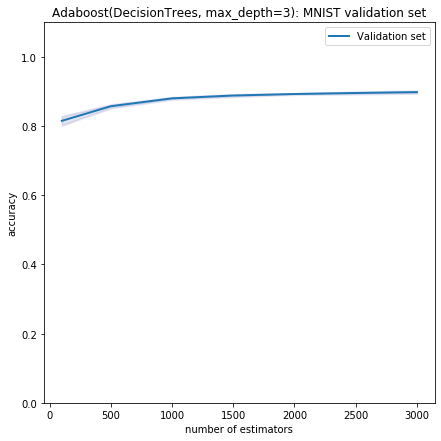

In [50]:
def print_mnist_adaboost_n_estimators_cv5():
    n_estimators = [100, 500, 1000, 1500, 2000, 2500, 3000]

    # Scores taken from cv=5 cross_validation performed previously-- see above
    cv_5_scores = [
        [0.83491071, 0.80973214, 0.79723214, 0.809375  , 0.82419643], # n_est=100,  depth=3
        [0.85776786, 0.864375  , 0.855625  , 0.84883929, 0.85991071], # n_est=500,  depth=3
        [0.88169643, 0.88392857, 0.87589286, 0.88205357, 0.87696429], # n_est=1000, depth=3
        [0.89196429, 0.89160714, 0.88642857, 0.88848214, 0.88303571], # n_est=1500, depth=3
        [0.89392857, 0.89205357, 0.89125   , 0.895     , 0.89098214], # n_est=2000, depth=3
        [0.89607143, 0.90089286, 0.89232143, 0.89660714, 0.89205357], # n_est=2500, depth=3
        [0.89883929, 0.90401786, 0.89392857, 0.89910714, 0.89473214], # n_est=3000, depth=3
    ]
    s = np.array(cv_5_scores)

    s_mean = s.mean(axis=1)
    s_std = s.std(axis=1)

    plt.xlabel("number of estimators")
    plt.ylabel("accuracy")
    plt.title("Adaboost(DecisionTrees, max_depth=3): MNIST validation set")
    plt.ylim(0.0, 1.1)
    plt.plot(n_estimators, s_mean, label="Validation set", lw=2)
    plt.fill_between(n_estimators, s_mean - s_std, s_mean + s_std, alpha=0.1, color="navy", lw=2)
    plt.legend(loc="best")
    plt.show()

print_mnist_adaboost_n_estimators_cv5()

## Learning Curves

AdaBoostClassifier(algorithm='SAMME.R',
                   base_estimator=DecisionTreeClassifier(ccp_alpha=0.0,
                                                         class_weight=None,
                                                         criterion='gini',
                                                         max_depth=1,
                                                         max_features=None,
                                                         max_leaf_nodes=None,
                                                         min_impurity_decrease=0.0,
                                                         min_impurity_split=None,
                                                         min_samples_leaf=1,
                                                         min_samples_split=2,
                                                         min_weight_fraction_leaf=0.0,
                                                         presort='deprecated',
                          

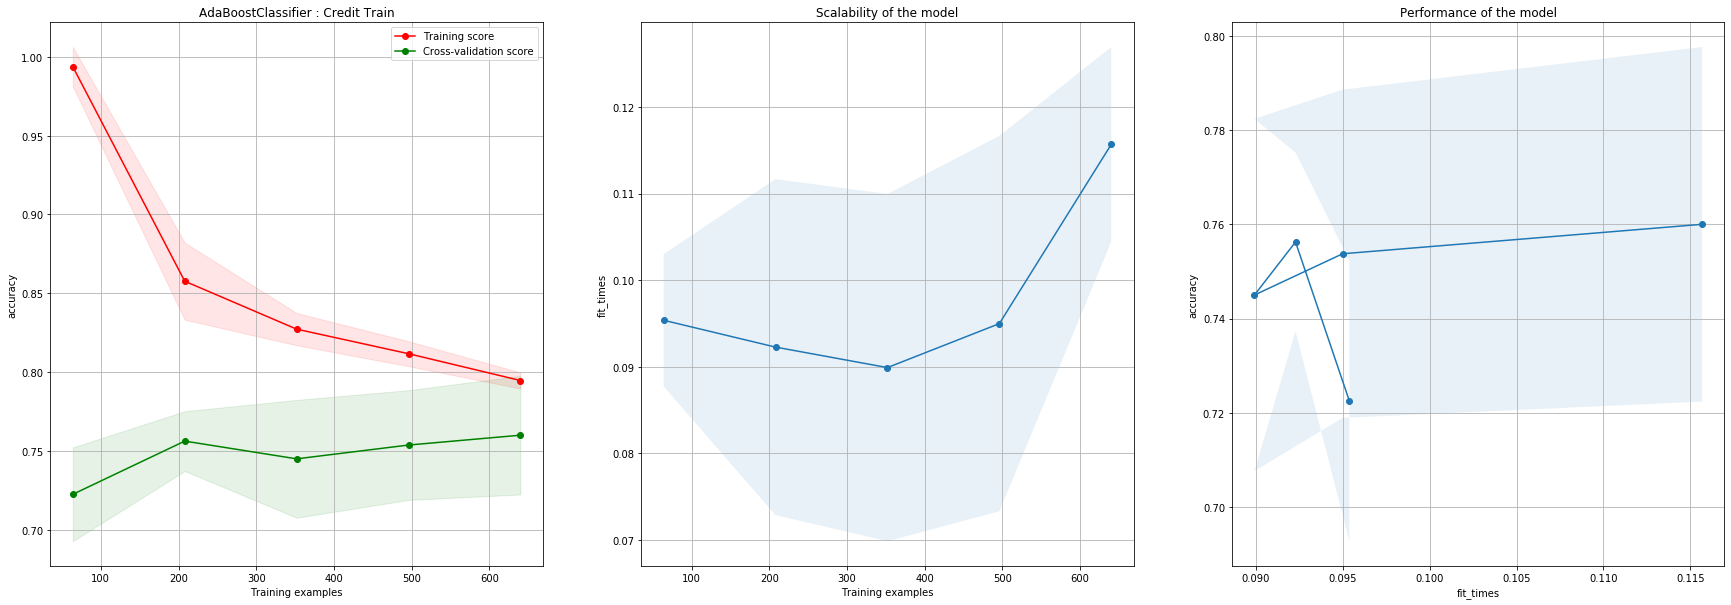

In [75]:
n_estimators = 50
max_depth = 1
splitter = "random"
cada = AdaBoostClassifier(DecisionTreeClassifier(max_depth=max_depth,
                                                 splitter=splitter),
                          n_estimators=n_estimators,
                          random_state=random_state)
build_learning_curve(cada, cred)

AdaBoostClassifier(algorithm='SAMME.R',
                   base_estimator=DecisionTreeClassifier(ccp_alpha=0.0,
                                                         class_weight=None,
                                                         criterion='gini',
                                                         max_depth=1,
                                                         max_features=None,
                                                         max_leaf_nodes=None,
                                                         min_impurity_decrease=0.0,
                                                         min_impurity_split=None,
                                                         min_samples_leaf=1,
                                                         min_samples_split=2,
                                                         min_weight_fraction_leaf=0.0,
                                                         presort='deprecated',
                          

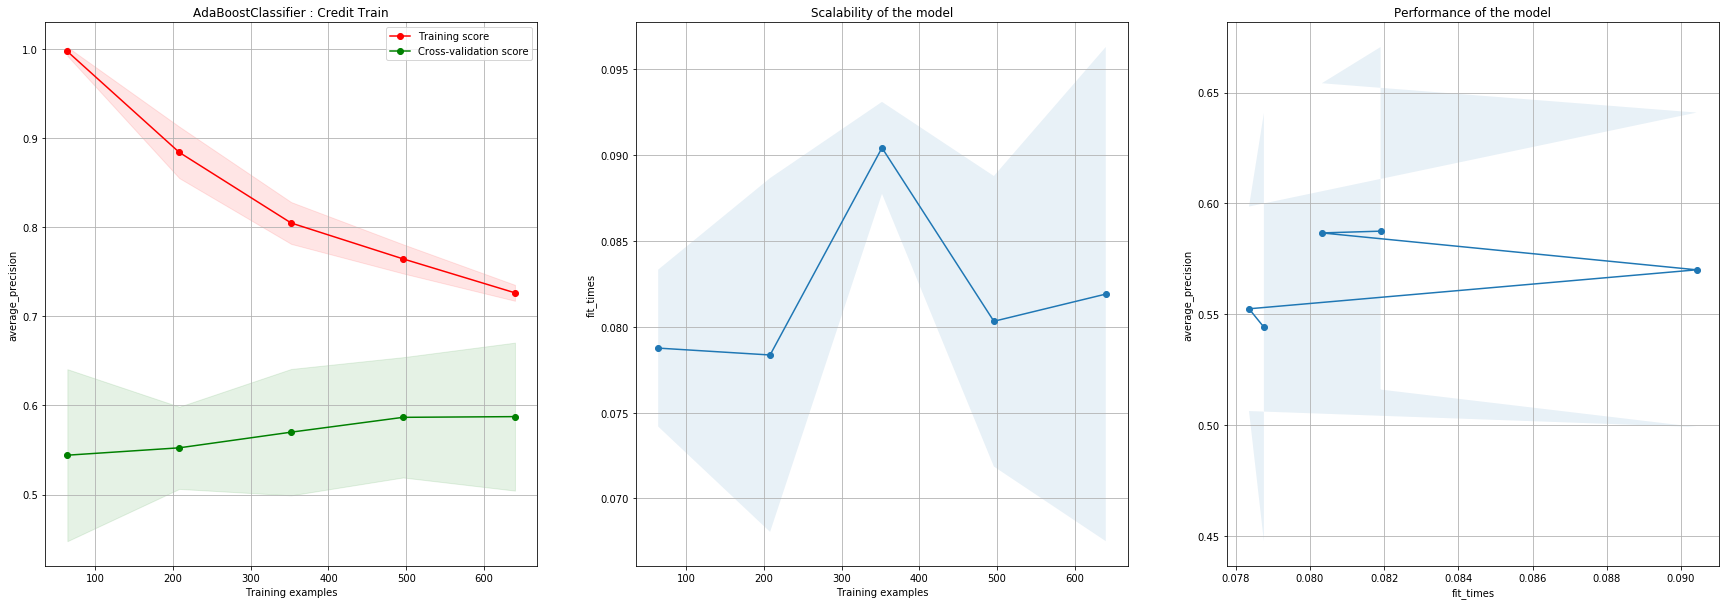

In [76]:
n_estimators = 50
max_depth = 1
splitter = "random"
cada = AdaBoostClassifier(DecisionTreeClassifier(max_depth=max_depth,
                                                 splitter=splitter),
                          n_estimators=n_estimators,
                          random_state=random_state)
build_learning_curve(cada, cred, scoring="average_precision")

AdaBoostClassifier(algorithm='SAMME.R',
                   base_estimator=DecisionTreeClassifier(ccp_alpha=0.0,
                                                         class_weight=None,
                                                         criterion='gini',
                                                         max_depth=1,
                                                         max_features=None,
                                                         max_leaf_nodes=None,
                                                         min_impurity_decrease=0.0,
                                                         min_impurity_split=None,
                                                         min_samples_leaf=1,
                                                         min_samples_split=2,
                                                         min_weight_fraction_leaf=0.0,
                                                         presort='deprecated',
                          

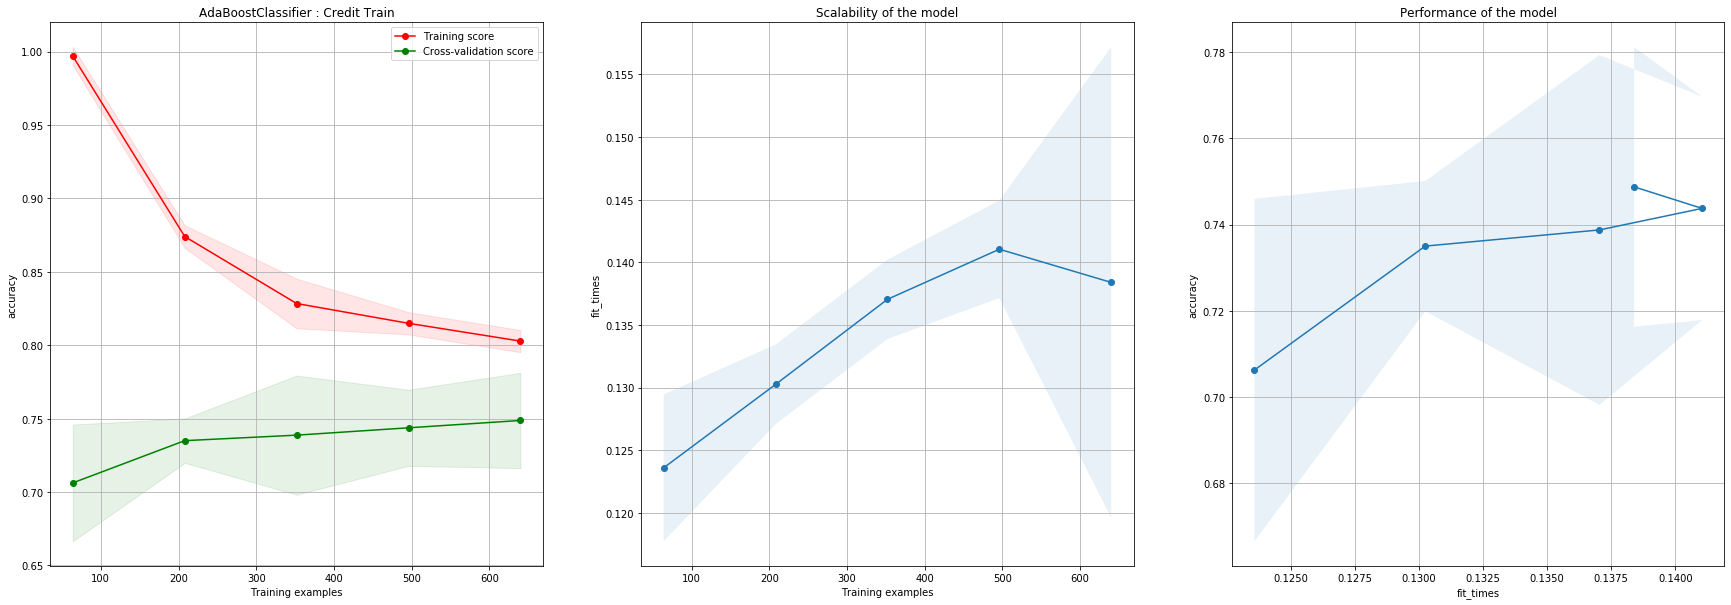

In [77]:
n_estimators = 75
max_depth = 1
splitter = "random"
cada = AdaBoostClassifier(DecisionTreeClassifier(max_depth=max_depth,
                                                 splitter=splitter),
                          n_estimators=n_estimators,
                          random_state=random_state)
build_learning_curve(cada, cred)

AdaBoostClassifier(algorithm='SAMME.R',
                   base_estimator=DecisionTreeClassifier(ccp_alpha=0.0,
                                                         class_weight=None,
                                                         criterion='gini',
                                                         max_depth=1,
                                                         max_features=None,
                                                         max_leaf_nodes=None,
                                                         min_impurity_decrease=0.0,
                                                         min_impurity_split=None,
                                                         min_samples_leaf=1,
                                                         min_samples_split=2,
                                                         min_weight_fraction_leaf=0.0,
                                                         presort='deprecated',
                          

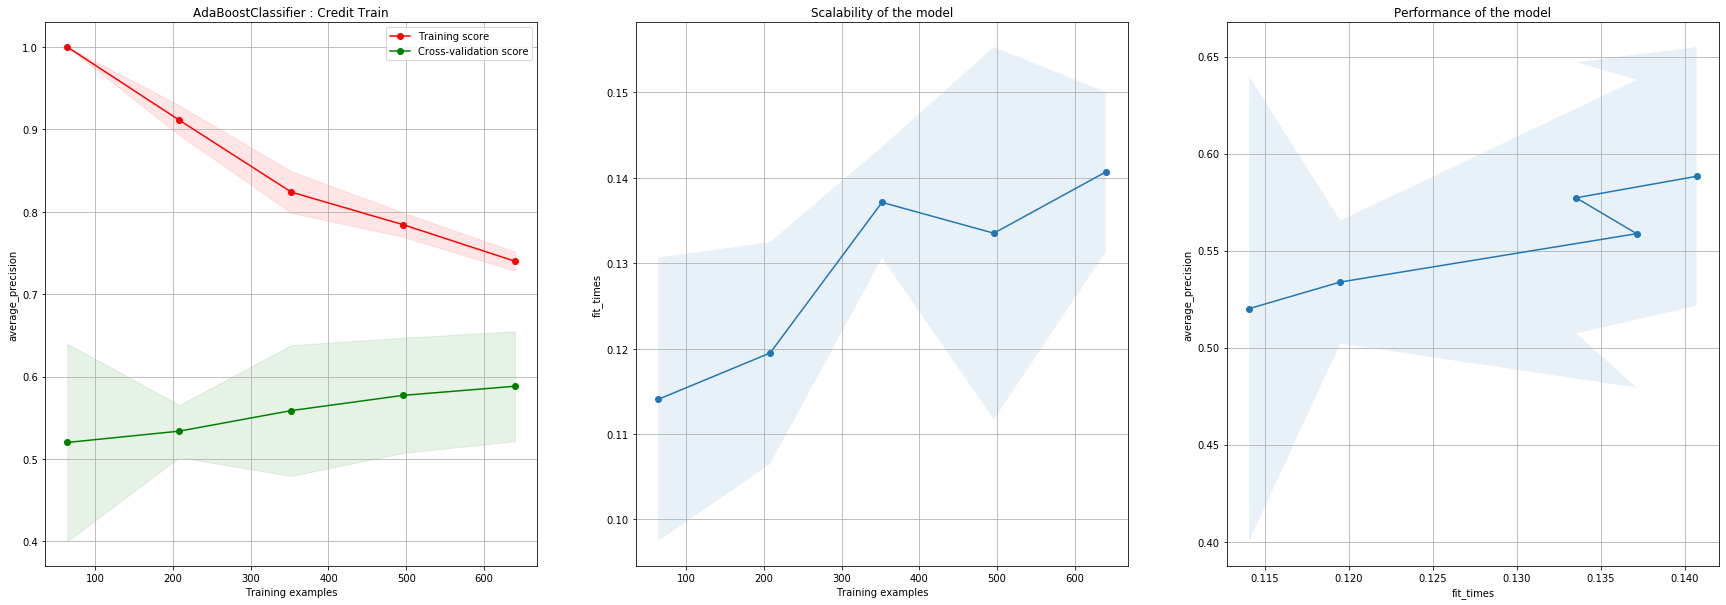

In [78]:
n_estimators = 75
max_depth = 1
splitter = "random"
cada = AdaBoostClassifier(DecisionTreeClassifier(max_depth=max_depth,
                                                 splitter=splitter),
                          n_estimators=n_estimators,
                          random_state=random_state)
build_learning_curve(cada, cred, scoring="average_precision")

AdaBoostClassifier(algorithm='SAMME.R',
                   base_estimator=DecisionTreeClassifier(ccp_alpha=0.0,
                                                         class_weight=None,
                                                         criterion='gini',
                                                         max_depth=1,
                                                         max_features=None,
                                                         max_leaf_nodes=None,
                                                         min_impurity_decrease=0.0,
                                                         min_impurity_split=None,
                                                         min_samples_leaf=1,
                                                         min_samples_split=2,
                                                         min_weight_fraction_leaf=0.0,
                                                         presort='deprecated',
                          

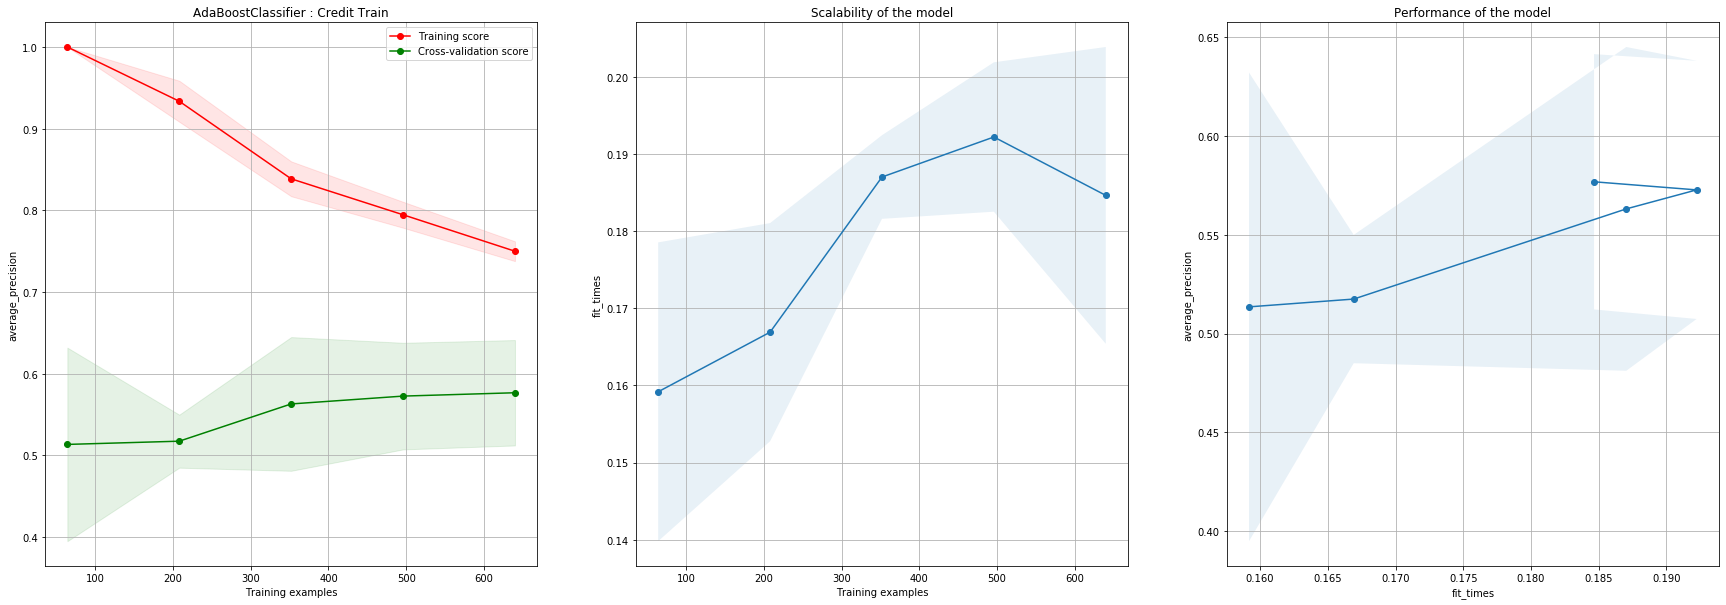

In [79]:
n_estimators = 100
max_depth = 1
splitter = "random"
cada = AdaBoostClassifier(DecisionTreeClassifier(max_depth=max_depth,
                                                 splitter=splitter),
                          n_estimators=n_estimators,
                          random_state=random_state)
build_learning_curve(cada, cred, scoring="average_precision")

AdaBoostClassifier(algorithm='SAMME.R',
                   base_estimator=DecisionTreeClassifier(ccp_alpha=0.0,
                                                         class_weight=None,
                                                         criterion='gini',
                                                         max_depth=2,
                                                         max_features=None,
                                                         max_leaf_nodes=None,
                                                         min_impurity_decrease=0.0,
                                                         min_impurity_split=None,
                                                         min_samples_leaf=1,
                                                         min_samples_split=2,
                                                         min_weight_fraction_leaf=0.0,
                                                         presort='deprecated',
                          

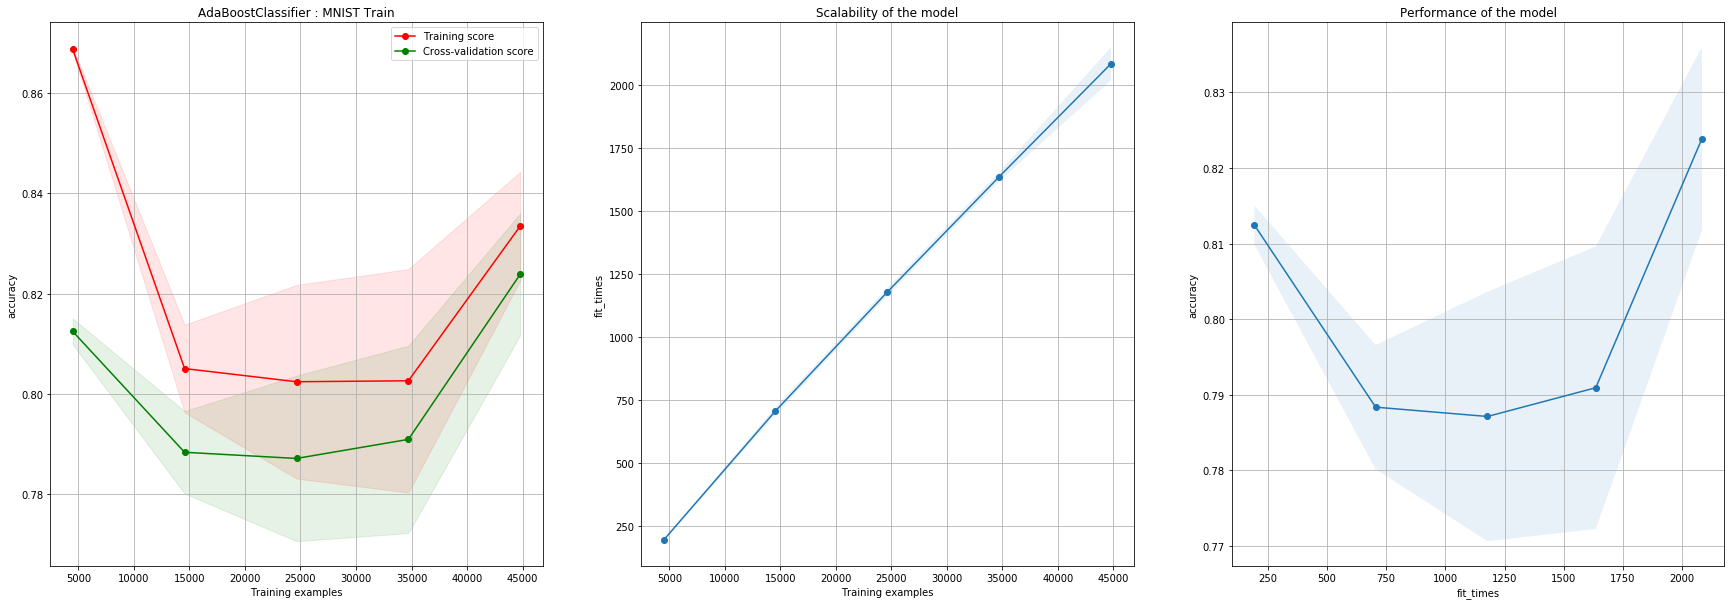

In [41]:
n_estimators = 1000
max_depth = 2
splitter = "random"
mada = AdaBoostClassifier(DecisionTreeClassifier(max_depth=max_depth,
                                                 splitter=splitter),
                          n_estimators=n_estimators,
                          random_state=random_state)
build_learning_curve(mada, mnist)

AdaBoostClassifier(algorithm='SAMME.R',
                   base_estimator=DecisionTreeClassifier(ccp_alpha=0.0,
                                                         class_weight=None,
                                                         criterion='gini',
                                                         max_depth=3,
                                                         max_features=None,
                                                         max_leaf_nodes=None,
                                                         min_impurity_decrease=0.0,
                                                         min_impurity_split=None,
                                                         min_samples_leaf=1,
                                                         min_samples_split=2,
                                                         min_weight_fraction_leaf=0.0,
                                                         presort='deprecated',
                          

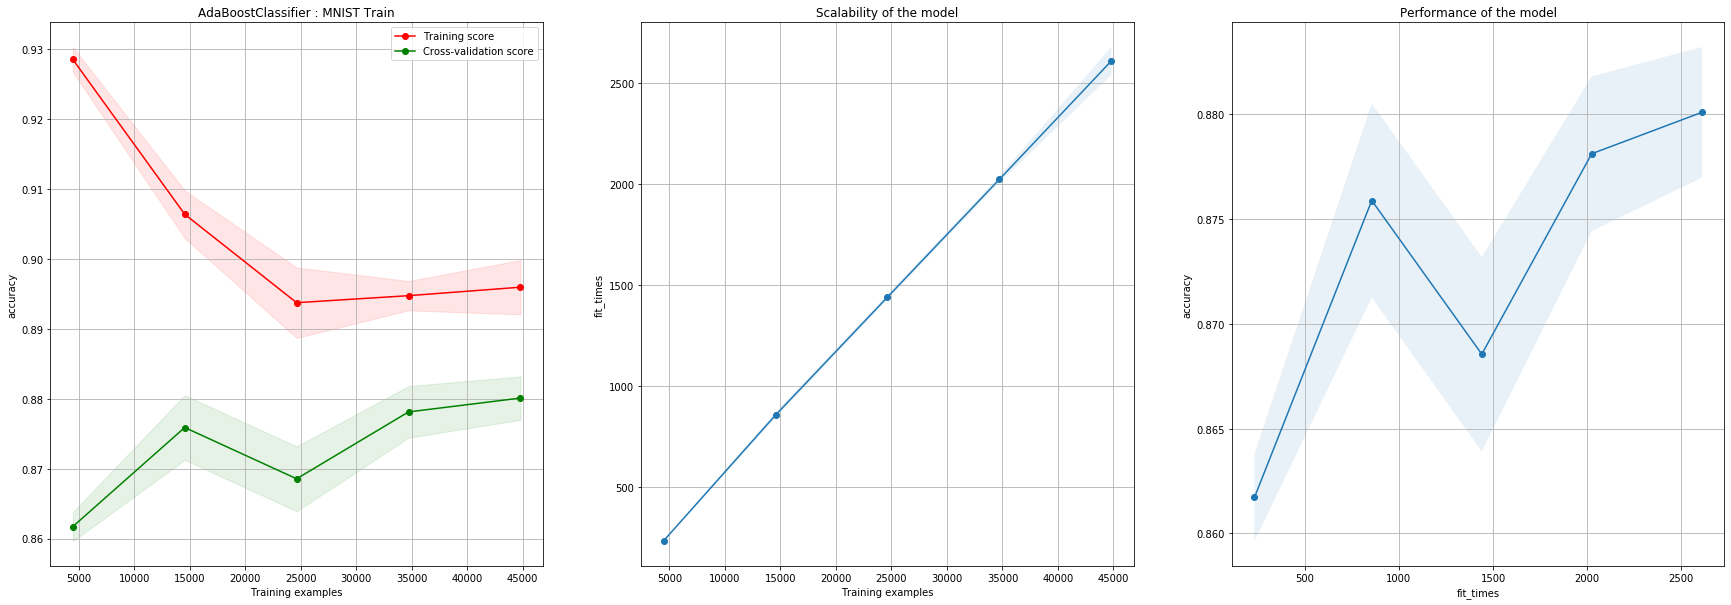

In [39]:
n_estimators = 1000
max_depth = 3
splitter = "random"
mada = AdaBoostClassifier(DecisionTreeClassifier(max_depth=max_depth,
                                                 splitter=splitter),
                          n_estimators=n_estimators,
                          random_state=random_state)
build_learning_curve(mada, mnist)

AdaBoostClassifier(algorithm='SAMME.R',
                   base_estimator=DecisionTreeClassifier(ccp_alpha=0.0,
                                                         class_weight=None,
                                                         criterion='gini',
                                                         max_depth=3,
                                                         max_features=None,
                                                         max_leaf_nodes=None,
                                                         min_impurity_decrease=0.0,
                                                         min_impurity_split=None,
                                                         min_samples_leaf=1,
                                                         min_samples_split=2,
                                                         min_weight_fraction_leaf=0.0,
                                                         presort='deprecated',
                          

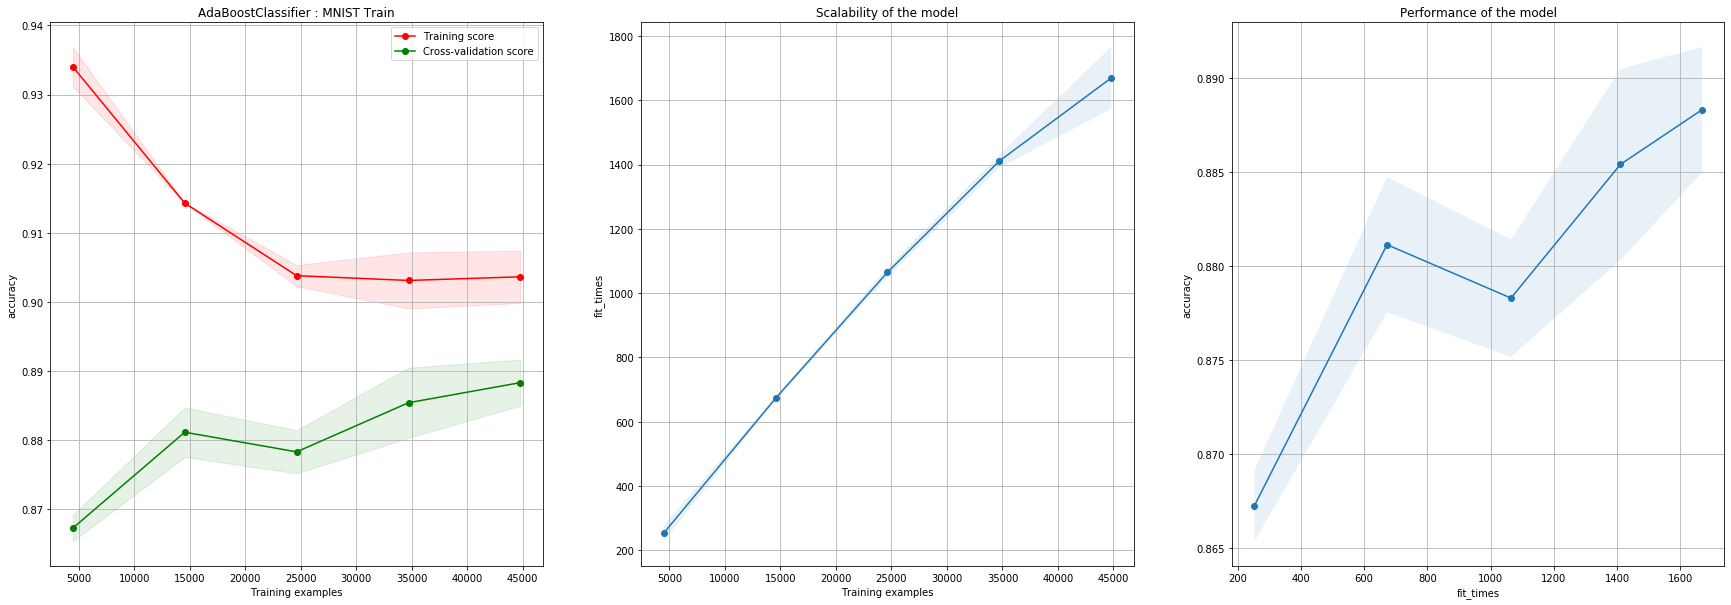

In [42]:
n_estimators = 1500
max_depth = 3
splitter = "random"
mada = AdaBoostClassifier(DecisionTreeClassifier(max_depth=max_depth,
                                                 splitter=splitter),
                          n_estimators=n_estimators,
                          random_state=random_state)
build_learning_curve(mada, mnist)

AdaBoostClassifier(algorithm='SAMME.R',
                   base_estimator=DecisionTreeClassifier(ccp_alpha=0.0,
                                                         class_weight=None,
                                                         criterion='gini',
                                                         max_depth=3,
                                                         max_features=None,
                                                         max_leaf_nodes=None,
                                                         min_impurity_decrease=0.0,
                                                         min_impurity_split=None,
                                                         min_samples_leaf=1,
                                                         min_samples_split=2,
                                                         min_weight_fraction_leaf=0.0,
                                                         presort='deprecated',
                          

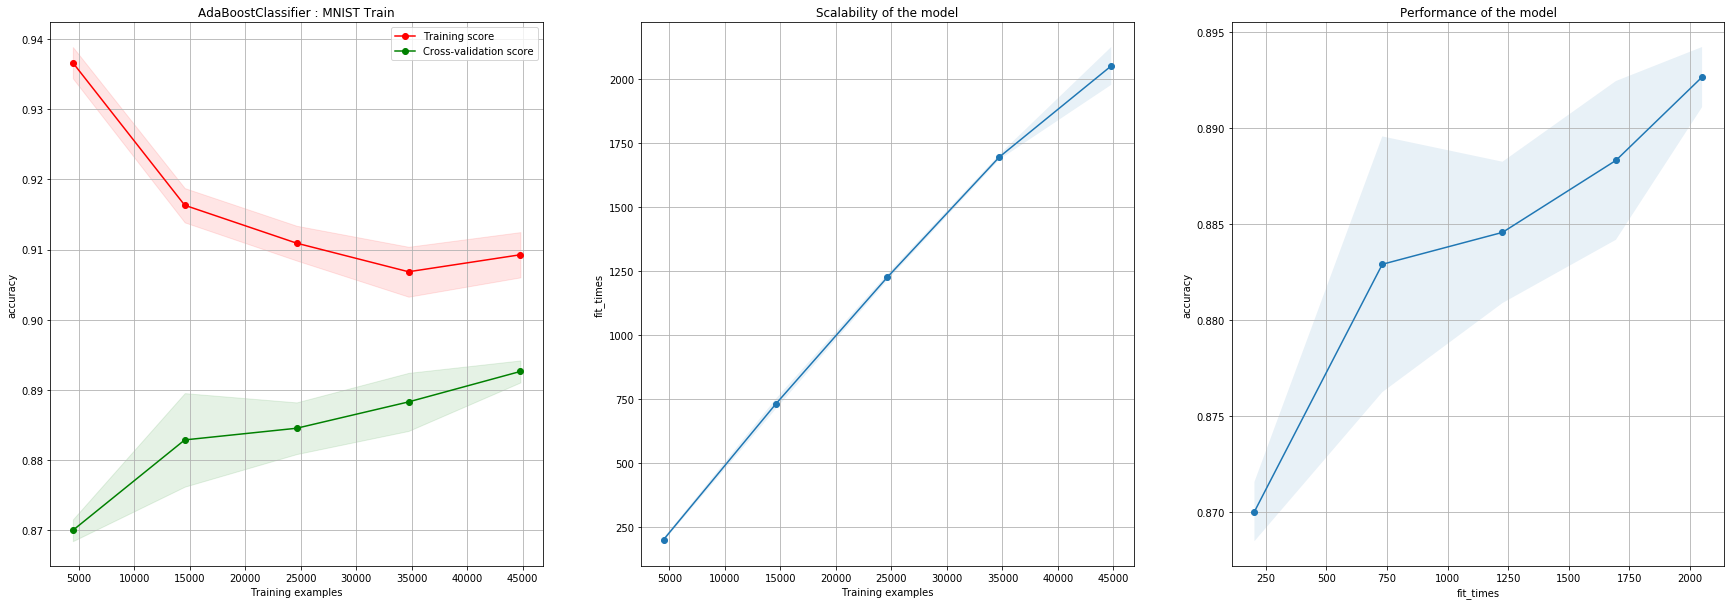

In [43]:
n_estimators = 2000
max_depth = 3
splitter = "random"
mada = AdaBoostClassifier(DecisionTreeClassifier(max_depth=max_depth,
                                                 splitter=splitter),
                          n_estimators=n_estimators,
                          random_state=random_state)
build_learning_curve(mada, mnist)

AdaBoostClassifier(algorithm='SAMME.R',
                   base_estimator=DecisionTreeClassifier(ccp_alpha=0.0,
                                                         class_weight=None,
                                                         criterion='gini',
                                                         max_depth=4,
                                                         max_features=None,
                                                         max_leaf_nodes=None,
                                                         min_impurity_decrease=0.0,
                                                         min_impurity_split=None,
                                                         min_samples_leaf=1,
                                                         min_samples_split=2,
                                                         min_weight_fraction_leaf=0.0,
                                                         presort='deprecated',
                          

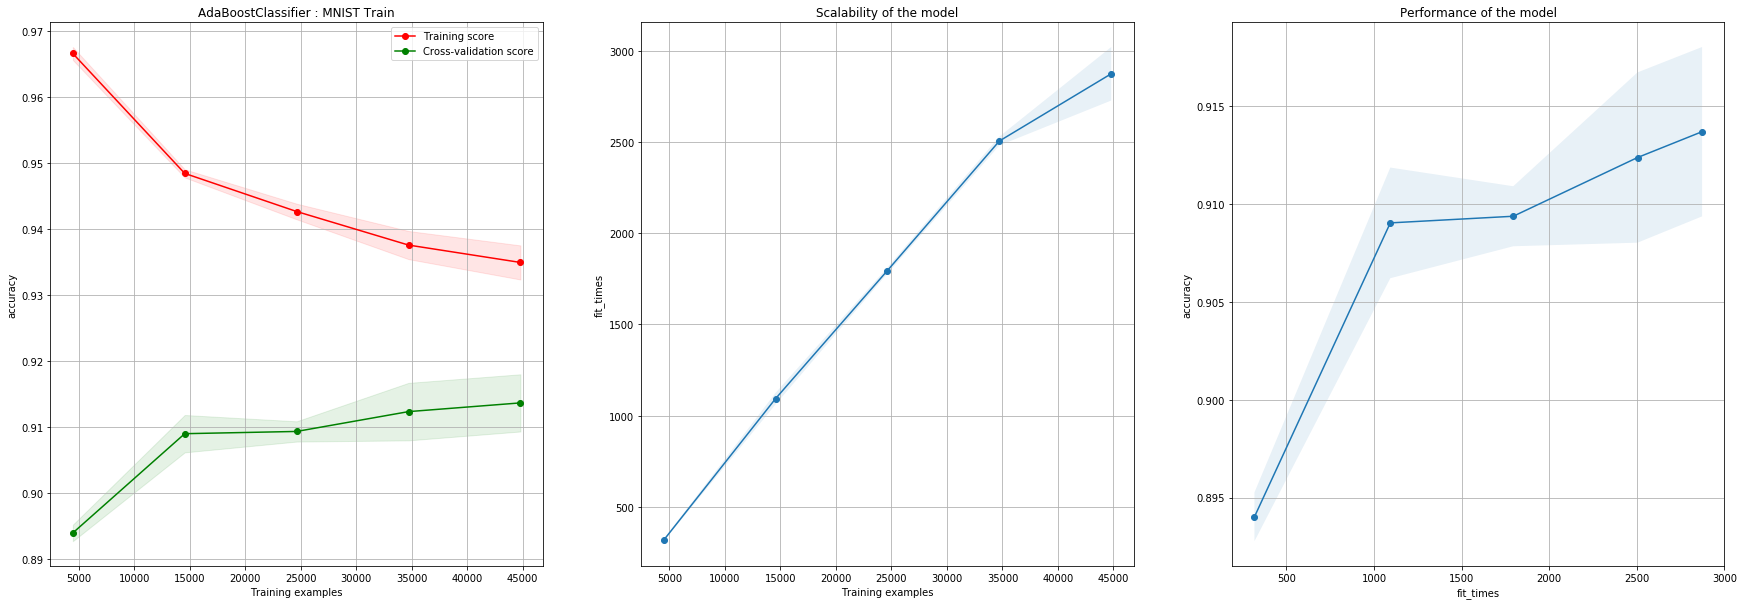

In [40]:
n_estimators = 1000
max_depth = 4
splitter = "random"
mada = AdaBoostClassifier(DecisionTreeClassifier(max_depth=max_depth,
                                                 splitter=splitter),
                          n_estimators=n_estimators,
                          random_state=random_state)
build_learning_curve(mada, mnist)

AdaBoostClassifier(algorithm='SAMME.R',
                   base_estimator=DecisionTreeClassifier(ccp_alpha=0.0,
                                                         class_weight=None,
                                                         criterion='gini',
                                                         max_depth=4,
                                                         max_features=None,
                                                         max_leaf_nodes=None,
                                                         min_impurity_decrease=0.0,
                                                         min_impurity_split=None,
                                                         min_samples_leaf=1,
                                                         min_samples_split=2,
                                                         min_weight_fraction_leaf=0.0,
                                                         presort='deprecated',
                          

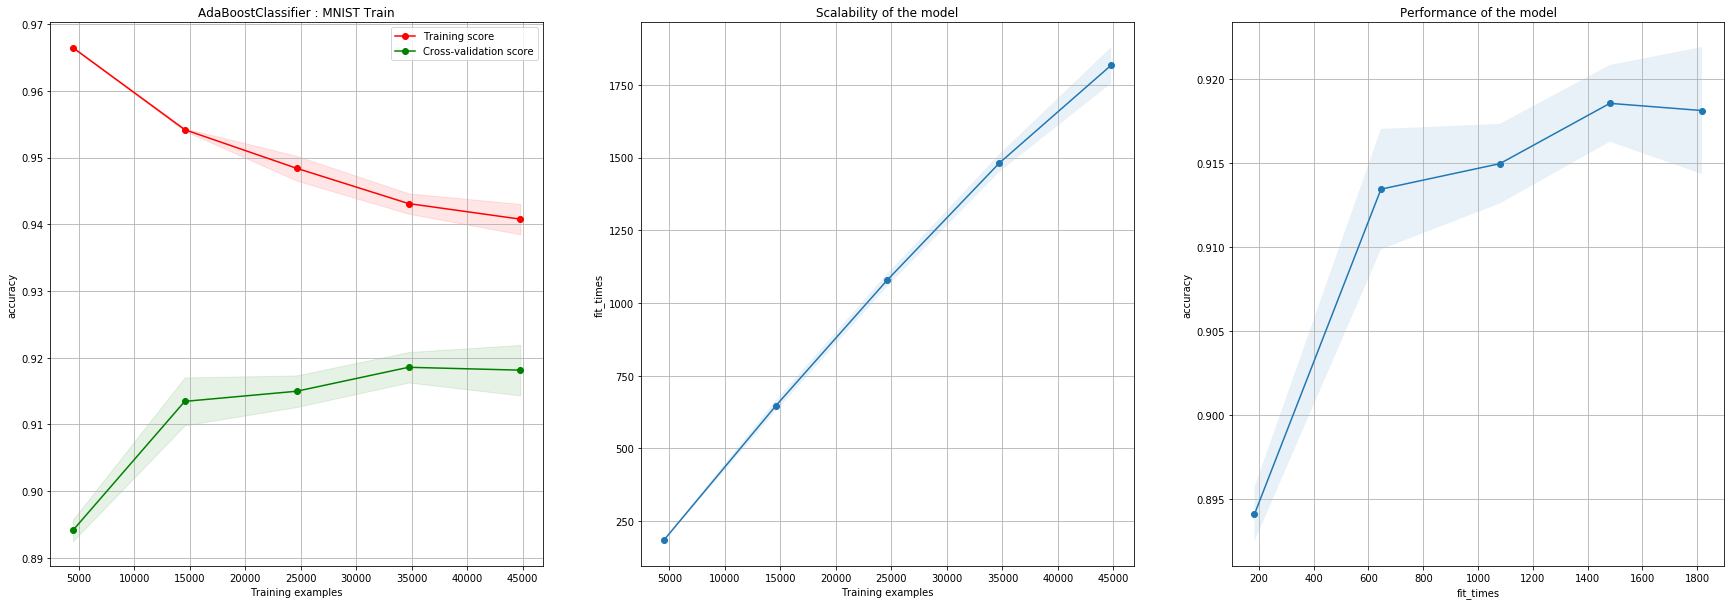

In [44]:
n_estimators = 1500
max_depth = 4
splitter = "random"
mada = AdaBoostClassifier(DecisionTreeClassifier(max_depth=max_depth,
                                                 splitter=splitter),
                          n_estimators=n_estimators,
                          random_state=random_state)
build_learning_curve(mada, mnist)

AdaBoostClassifier(algorithm='SAMME.R',
                   base_estimator=DecisionTreeClassifier(ccp_alpha=0.0,
                                                         class_weight=None,
                                                         criterion='gini',
                                                         max_depth=10,
                                                         max_features=None,
                                                         max_leaf_nodes=None,
                                                         min_impurity_decrease=0.0,
                                                         min_impurity_split=None,
                                                         min_samples_leaf=1,
                                                         min_samples_split=2,
                                                         min_weight_fraction_leaf=0.0,
                                                         presort='deprecated',
                         

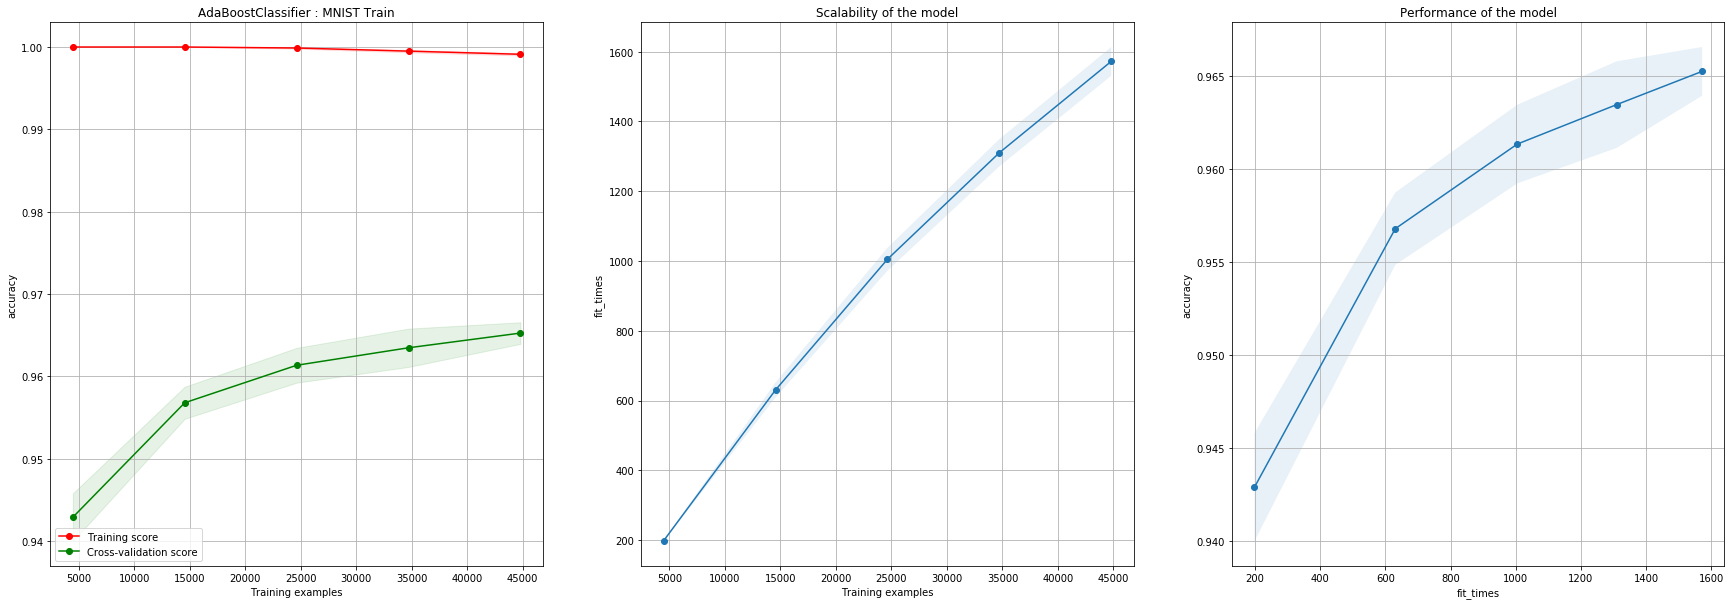

In [29]:
n_estimators = 500
max_depth = 10
splitter = "random"
mada = AdaBoostClassifier(DecisionTreeClassifier(max_depth=max_depth,
                                                 splitter=splitter),
                          n_estimators=n_estimators,
                          random_state=random_state)
build_learning_curve(mada, mnist)

AdaBoostClassifier(algorithm='SAMME.R',
                   base_estimator=DecisionTreeClassifier(ccp_alpha=0.0,
                                                         class_weight=None,
                                                         criterion='gini',
                                                         max_depth=15,
                                                         max_features=None,
                                                         max_leaf_nodes=None,
                                                         min_impurity_decrease=0.0,
                                                         min_impurity_split=None,
                                                         min_samples_leaf=1,
                                                         min_samples_split=2,
                                                         min_weight_fraction_leaf=0.0,
                                                         presort='deprecated',
                         

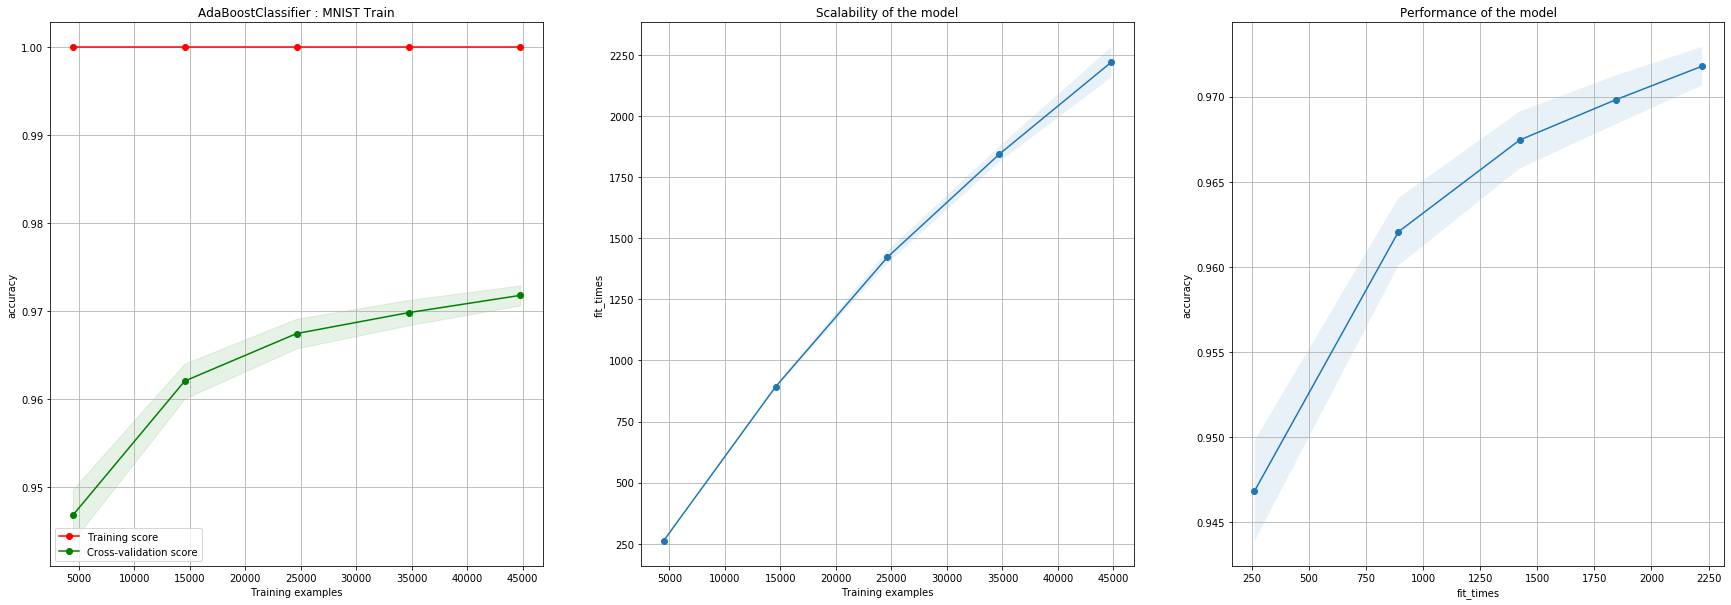

In [26]:
n_estimators = 500
max_depth = 15
splitter = "random"
mada = AdaBoostClassifier(DecisionTreeClassifier(max_depth=max_depth,
                                                 splitter=splitter),
                          n_estimators=n_estimators,
                          random_state=random_state)
build_learning_curve(mada, mnist)

AdaBoostClassifier(algorithm='SAMME.R',
                   base_estimator=DecisionTreeClassifier(ccp_alpha=0.0,
                                                         class_weight=None,
                                                         criterion='gini',
                                                         max_depth=9,
                                                         max_features=None,
                                                         max_leaf_nodes=None,
                                                         min_impurity_decrease=0.0,
                                                         min_impurity_split=None,
                                                         min_samples_leaf=1,
                                                         min_samples_split=2,
                                                         min_weight_fraction_leaf=0.0,
                                                         presort='deprecated',
                          

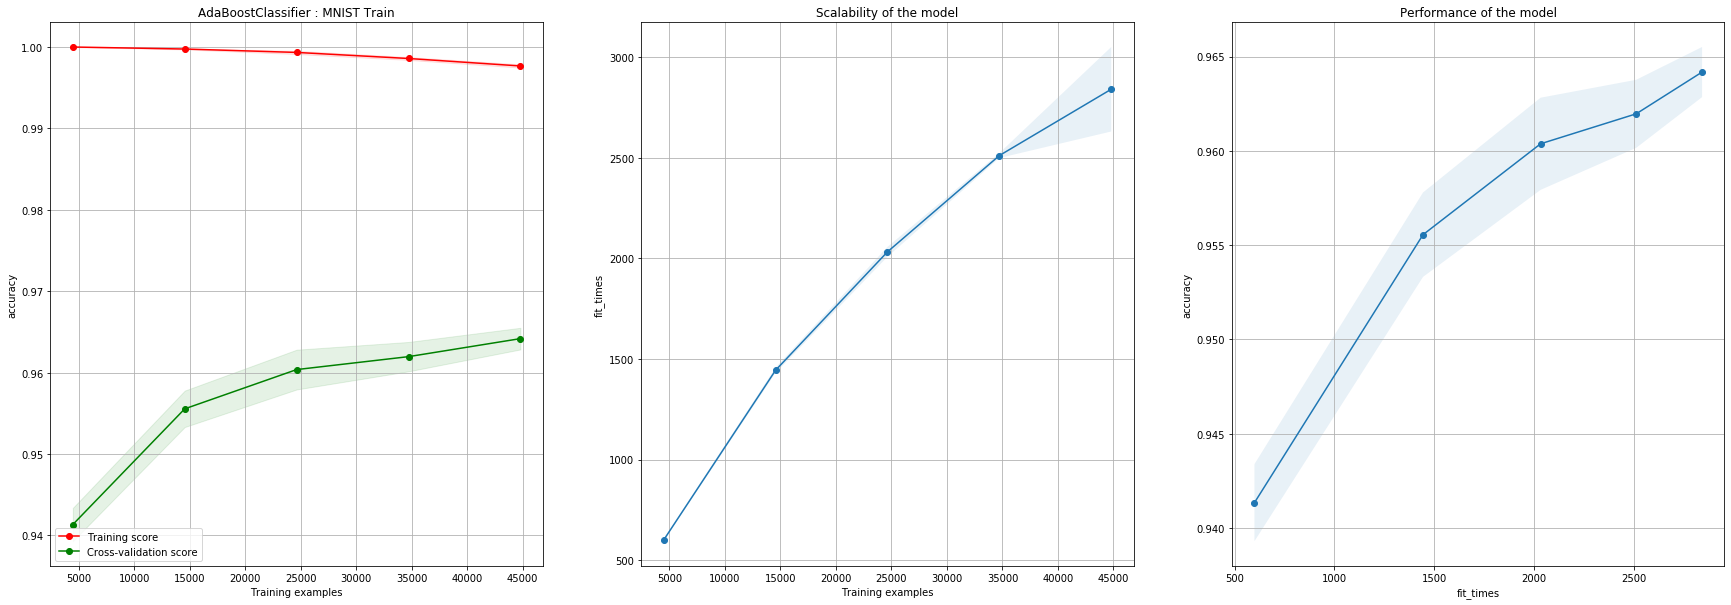

In [63]:
n_estimators = 1000
max_depth = 9
splitter = "random"
mada = AdaBoostClassifier(DecisionTreeClassifier(max_depth=max_depth,
                                                 splitter=splitter),
                          n_estimators=n_estimators,
                          random_state=random_state)
build_learning_curve(mada, mnist)

AdaBoostClassifier(algorithm='SAMME.R',
                   base_estimator=DecisionTreeClassifier(ccp_alpha=0.0,
                                                         class_weight=None,
                                                         criterion='gini',
                                                         max_depth=10,
                                                         max_features=None,
                                                         max_leaf_nodes=None,
                                                         min_impurity_decrease=0.0,
                                                         min_impurity_split=None,
                                                         min_samples_leaf=1,
                                                         min_samples_split=2,
                                                         min_weight_fraction_leaf=0.0,
                                                         presort='deprecated',
                         

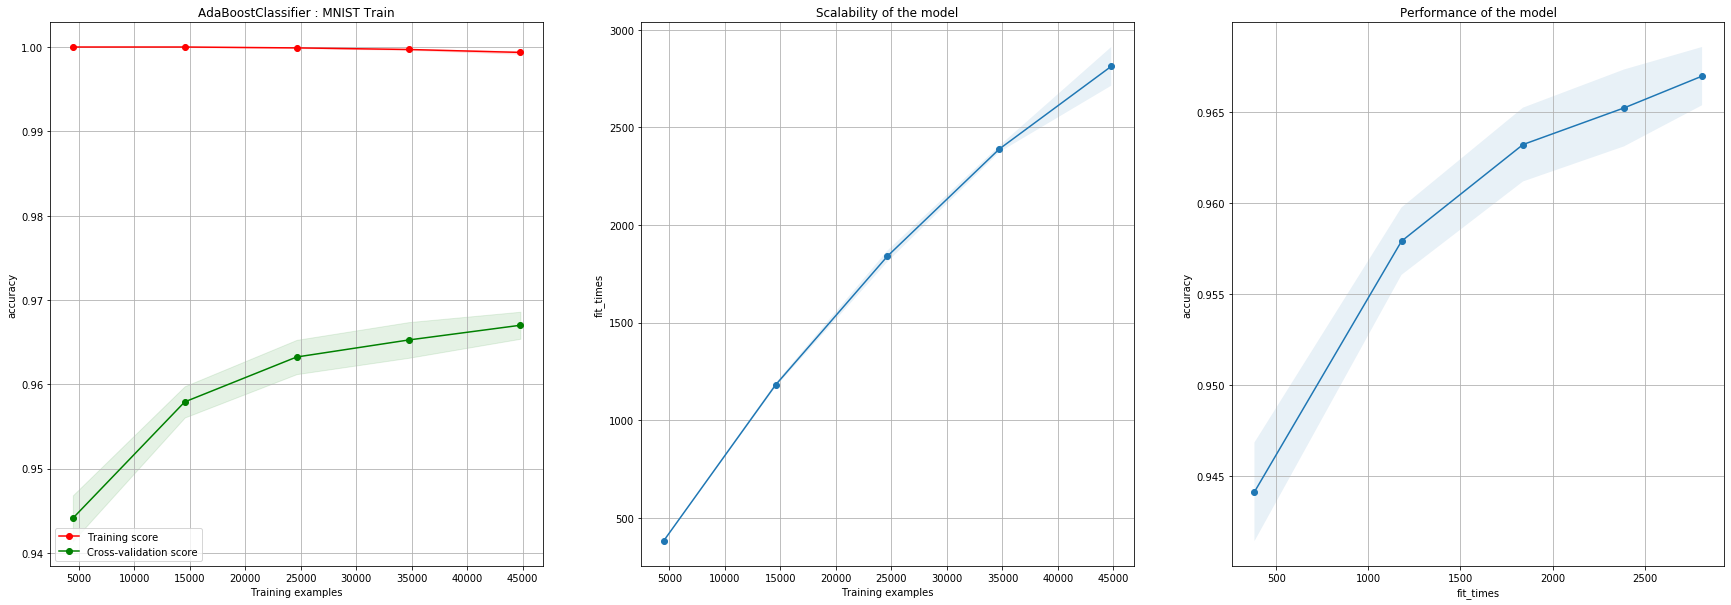

In [51]:
n_estimators = 1000
max_depth = 10
splitter = "random"
mada = AdaBoostClassifier(DecisionTreeClassifier(max_depth=max_depth,
                                                 splitter=splitter),
                          n_estimators=n_estimators,
                          random_state=random_state)
build_learning_curve(mada, mnist)

## Model Complexity Analysis

AdaBoostClassifier(algorithm='SAMME.R',
                   base_estimator=DecisionTreeClassifier(ccp_alpha=0.0,
                                                         class_weight=None,
                                                         criterion='gini',
                                                         max_depth=1,
                                                         max_features=None,
                                                         max_leaf_nodes=None,
                                                         min_impurity_decrease=0.0,
                                                         min_impurity_split=None,
                                                         min_samples_leaf=1,
                                                         min_samples_split=2,
                                                         min_weight_fraction_leaf=0.0,
                                                         presort='deprecated',
                          

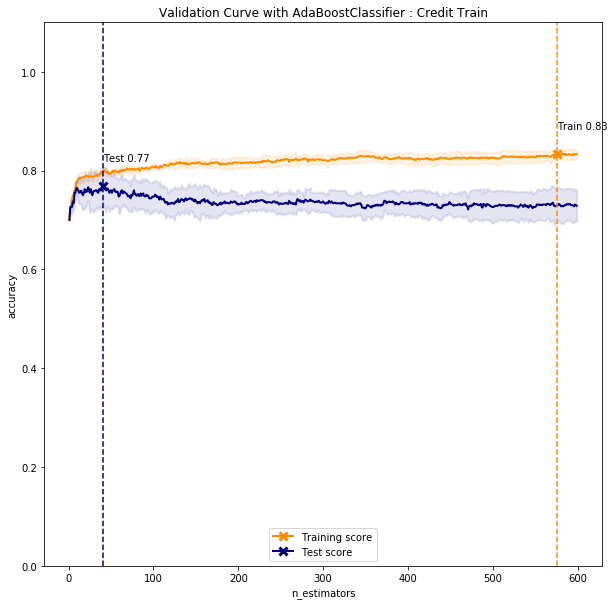

In [33]:
n_estimators = 50
max_depth = 1
splitter = "random"
cada = AdaBoostClassifier(DecisionTreeClassifier(max_depth=max_depth,
                                                 splitter=splitter),
                          n_estimators=n_estimators,
                          random_state=random_state)
build_validation_curve(cada, cred, param_name="n_estimators", param_range=range(1,600))

AdaBoostClassifier(algorithm='SAMME.R',
                   base_estimator=DecisionTreeClassifier(ccp_alpha=0.0,
                                                         class_weight=None,
                                                         criterion='gini',
                                                         max_depth=1,
                                                         max_features=None,
                                                         max_leaf_nodes=None,
                                                         min_impurity_decrease=0.0,
                                                         min_impurity_split=None,
                                                         min_samples_leaf=1,
                                                         min_samples_split=2,
                                                         min_weight_fraction_leaf=0.0,
                                                         presort='deprecated',
                          

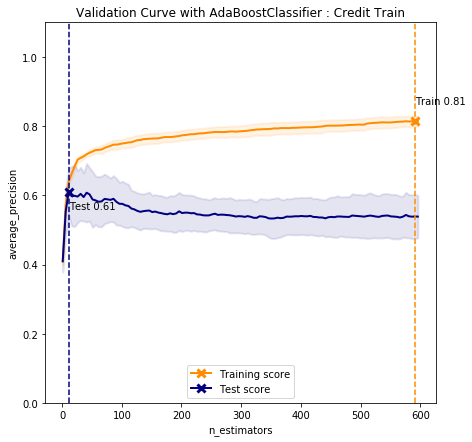

In [101]:
n_estimators = 50
max_depth = 1
splitter = "random"
cada = AdaBoostClassifier(DecisionTreeClassifier(max_depth=max_depth,
                                                 splitter=splitter),
                          n_estimators=n_estimators,
                          random_state=random_state)
build_validation_curve(cada, cred, param_name="n_estimators", param_range=range(1,600, 5), scoring="average_precision")

AdaBoostClassifier(algorithm='SAMME.R',
                   base_estimator=DecisionTreeClassifier(ccp_alpha=0.0,
                                                         class_weight=None,
                                                         criterion='gini',
                                                         max_depth=3,
                                                         max_features=None,
                                                         max_leaf_nodes=None,
                                                         min_impurity_decrease=0.0,
                                                         min_impurity_split=None,
                                                         min_samples_leaf=1,
                                                         min_samples_split=2,
                                                         min_weight_fraction_leaf=0.0,
                                                         presort='deprecated',
                          

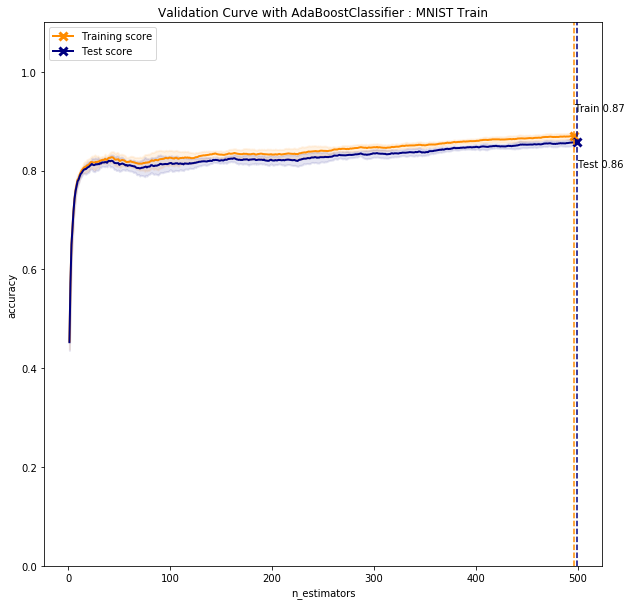

In [22]:
n_estimators = 300
max_depth = 3
splitter = "random"
mada = AdaBoostClassifier(DecisionTreeClassifier(max_depth=max_depth,
                                                 splitter=splitter),
                          n_estimators=n_estimators,
                          random_state=random_state)
build_validation_curve(mada, mnist, param_name="n_estimators", param_range=range(1,500))

AdaBoostClassifier(algorithm='SAMME.R',
                   base_estimator=DecisionTreeClassifier(ccp_alpha=0.0,
                                                         class_weight=None,
                                                         criterion='gini',
                                                         max_depth=4,
                                                         max_features=None,
                                                         max_leaf_nodes=None,
                                                         min_impurity_decrease=0.0,
                                                         min_impurity_split=None,
                                                         min_samples_leaf=1,
                                                         min_samples_split=2,
                                                         min_weight_fraction_leaf=0.0,
                                                         presort='deprecated',
                          

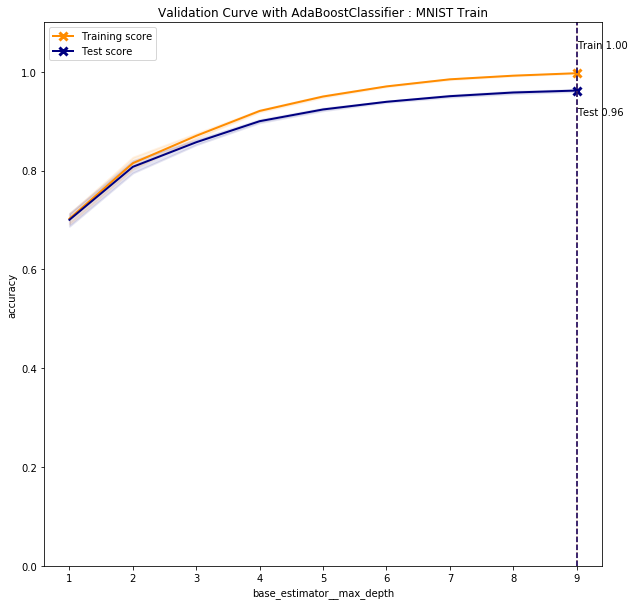

In [24]:
n_estimators = 500
max_depth = 4
splitter = "random"
mada = AdaBoostClassifier(DecisionTreeClassifier(max_depth=max_depth,
                                                 splitter=splitter),
                          n_estimators=n_estimators,
                          random_state=random_state)
build_validation_curve(mada, mnist, param_name="base_estimator__max_depth", param_range=range(1,10))

AdaBoostClassifier(algorithm='SAMME.R',
                   base_estimator=DecisionTreeClassifier(ccp_alpha=0.0,
                                                         class_weight=None,
                                                         criterion='gini',
                                                         max_depth=1,
                                                         max_features=None,
                                                         max_leaf_nodes=None,
                                                         min_impurity_decrease=0.0,
                                                         min_impurity_split=None,
                                                         min_samples_leaf=1,
                                                         min_samples_split=2,
                                                         min_weight_fraction_leaf=0.0,
                                                         presort='deprecated',
                          

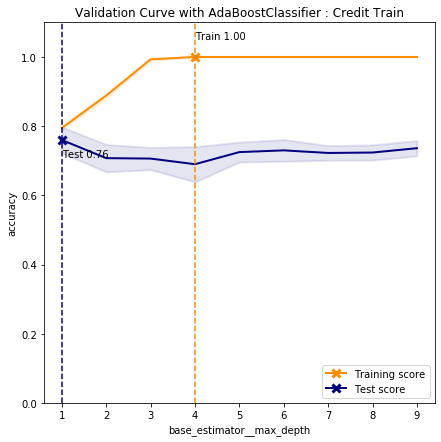

In [80]:
n_estimators = 50
max_depth = 1
splitter = "random"
cada = AdaBoostClassifier(DecisionTreeClassifier(max_depth=max_depth,
                                                 splitter=splitter),
                          n_estimators=n_estimators,
                          random_state=random_state)
build_validation_curve(cada, cred, param_name="base_estimator__max_depth", param_range=range(1, 10))

AdaBoostClassifier(algorithm='SAMME.R',
                   base_estimator=DecisionTreeClassifier(ccp_alpha=0.0,
                                                         class_weight=None,
                                                         criterion='gini',
                                                         max_depth=4,
                                                         max_features=None,
                                                         max_leaf_nodes=None,
                                                         min_impurity_decrease=0.0,
                                                         min_impurity_split=None,
                                                         min_samples_leaf=1,
                                                         min_samples_split=2,
                                                         min_weight_fraction_leaf=0.0,
                                                         presort='deprecated',
                          

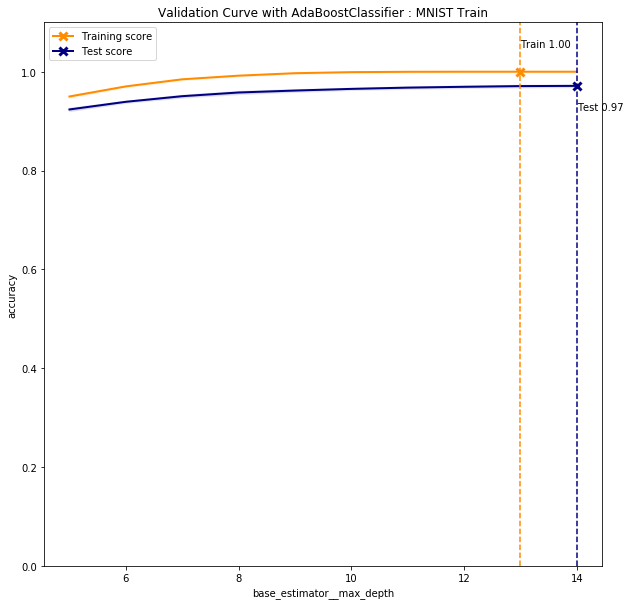

In [25]:
n_estimators = 500
max_depth = 4
splitter = "random"
mada = AdaBoostClassifier(DecisionTreeClassifier(max_depth=max_depth,
                                                 splitter=splitter),
                          n_estimators=n_estimators,
                          random_state=random_state)
build_validation_curve(mada, mnist, param_name="base_estimator__max_depth", param_range=range(5,15))

AdaBoostClassifier(algorithm='SAMME.R',
                   base_estimator=DecisionTreeClassifier(ccp_alpha=0.0,
                                                         class_weight=None,
                                                         criterion='gini',
                                                         max_depth=4,
                                                         max_features=None,
                                                         max_leaf_nodes=None,
                                                         min_impurity_decrease=0.0,
                                                         min_impurity_split=None,
                                                         min_samples_leaf=1,
                                                         min_samples_split=2,
                                                         min_weight_fraction_leaf=0.0,
                                                         presort='deprecated',
                          

/home/nikola/anaconda3/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


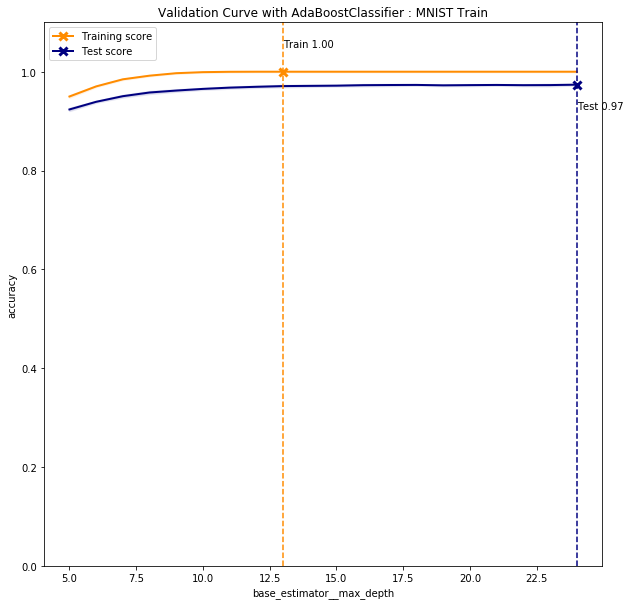

In [27]:
n_estimators = 500
max_depth = 4
splitter = "random"
mada = AdaBoostClassifier(DecisionTreeClassifier(max_depth=max_depth,
                                                 splitter=splitter),
                          n_estimators=n_estimators,
                          random_state=random_state)
build_validation_curve(mada, mnist, param_name="base_estimator__max_depth", param_range=range(5,25))

AdaBoostClassifier(algorithm='SAMME.R',
                   base_estimator=DecisionTreeClassifier(ccp_alpha=0.0,
                                                         class_weight=None,
                                                         criterion='gini',
                                                         max_depth=5,
                                                         max_features=None,
                                                         max_leaf_nodes=None,
                                                         min_impurity_decrease=0.0,
                                                         min_impurity_split=None,
                                                         min_samples_leaf=1,
                                                         min_samples_split=2,
                                                         min_weight_fraction_leaf=0.0,
                                                         presort='deprecated',
                          

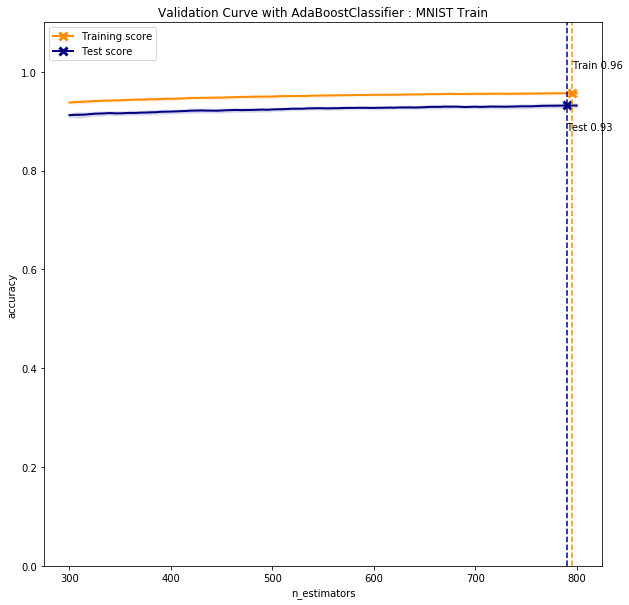

In [30]:
n_estimators = 500
max_depth = 5
splitter = "random"
mada = AdaBoostClassifier(DecisionTreeClassifier(max_depth=max_depth,
                                                 splitter=splitter),
                          n_estimators=n_estimators,
                          random_state=random_state)
build_validation_curve(mada, mnist, param_name="n_estimators", param_range=range(300,805,5))

AdaBoostClassifier(algorithm='SAMME.R',
                   base_estimator=DecisionTreeClassifier(ccp_alpha=0.0,
                                                         class_weight=None,
                                                         criterion='gini',
                                                         max_depth=3,
                                                         max_features=None,
                                                         max_leaf_nodes=None,
                                                         min_impurity_decrease=0.0,
                                                         min_impurity_split=None,
                                                         min_samples_leaf=1,
                                                         min_samples_split=2,
                                                         min_weight_fraction_leaf=0.0,
                                                         presort='deprecated',
                          

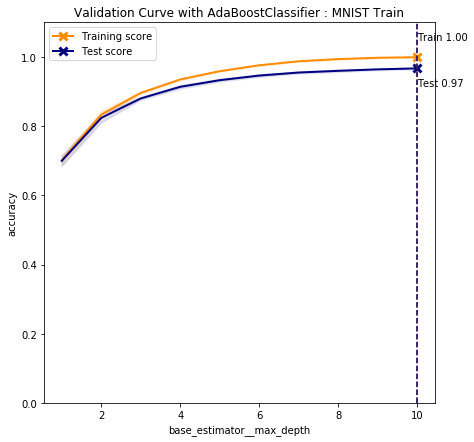

In [49]:
n_estimators = 1000
max_depth = 3
splitter = "random"
mada = AdaBoostClassifier(DecisionTreeClassifier(max_depth=max_depth,
                                                 splitter=splitter),
                          n_estimators=n_estimators,
                          random_state=random_state)
build_validation_curve(mada, mnist, param_name="base_estimator__max_depth", param_range=range(1,11))

AdaBoostClassifier(algorithm='SAMME.R',
                   base_estimator=DecisionTreeClassifier(ccp_alpha=0.0,
                                                         class_weight=None,
                                                         criterion='gini',
                                                         max_depth=3,
                                                         max_features=None,
                                                         max_leaf_nodes=None,
                                                         min_impurity_decrease=0.0,
                                                         min_impurity_split=None,
                                                         min_samples_leaf=1,
                                                         min_samples_split=2,
                                                         min_weight_fraction_leaf=0.0,
                                                         presort='deprecated',
                          

/home/nikola/anaconda3/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


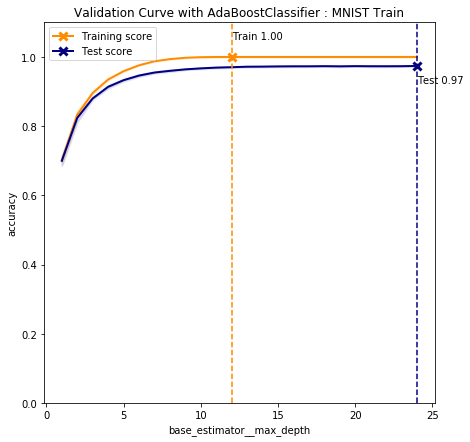

In [52]:
n_estimators = 1000
max_depth = 3
splitter = "random"
mada = AdaBoostClassifier(DecisionTreeClassifier(max_depth=max_depth,
                                                 splitter=splitter),
                          n_estimators=n_estimators,
                          random_state=random_state)
build_validation_curve(mada, mnist, param_name="base_estimator__max_depth", param_range=range(1,25))

AdaBoostClassifier(algorithm='SAMME.R',
                   base_estimator=DecisionTreeClassifier(ccp_alpha=0.0,
                                                         class_weight=None,
                                                         criterion='gini',
                                                         max_depth=1,
                                                         max_features=None,
                                                         max_leaf_nodes=None,
                                                         min_impurity_decrease=0.0,
                                                         min_impurity_split=None,
                                                         min_samples_leaf=1,
                                                         min_samples_split=2,
                                                         min_weight_fraction_leaf=0.0,
                                                         presort='deprecated',
                          

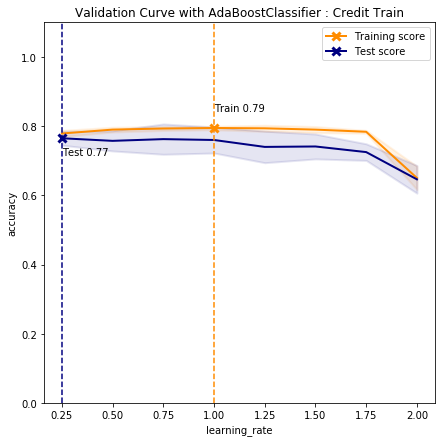

In [81]:
n_estimators = 50
max_depth = 1
splitter = "random"
cada = AdaBoostClassifier(DecisionTreeClassifier(max_depth=max_depth,
                                                 splitter=splitter),
                          n_estimators=n_estimators,
                          random_state=random_state)
build_validation_curve(cada, cred, param_name="learning_rate", param_range=np.linspace(0.25,2,8))

AdaBoostClassifier(algorithm='SAMME.R',
                   base_estimator=DecisionTreeClassifier(ccp_alpha=0.0,
                                                         class_weight=None,
                                                         criterion='gini',
                                                         max_depth=9,
                                                         max_features=None,
                                                         max_leaf_nodes=None,
                                                         min_impurity_decrease=0.0,
                                                         min_impurity_split=None,
                                                         min_samples_leaf=1,
                                                         min_samples_split=2,
                                                         min_weight_fraction_leaf=0.0,
                                                         presort='deprecated',
                          

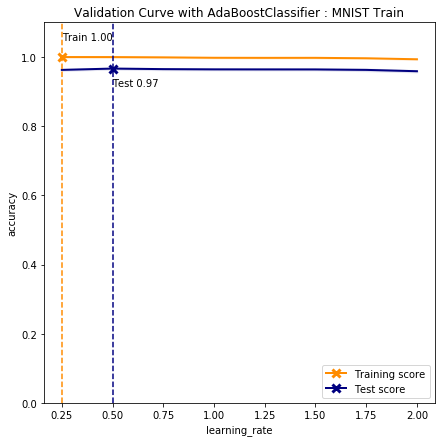

In [73]:
n_estimators = 1000
max_depth = 9
splitter = "random"
mada = AdaBoostClassifier(DecisionTreeClassifier(max_depth=max_depth,
                                                 splitter=splitter),
                          n_estimators=n_estimators,
                          random_state=random_state)
build_validation_curve(mada, mnist, param_name="learning_rate", param_range=np.linspace(0.25,2,8))

### Grid Search

In [ ]:
# No grid search performed

## Fit

In [89]:
# Credit Boosting
n_estimators = 50
max_depth = 1
splitter = "random"
learning_rate = 1
cada = AdaBoostClassifier(DecisionTreeClassifier(max_depth=max_depth,
                                                 splitter=splitter),
                          n_estimators=n_estimators,
                          learning_rate=learning_rate,
                          random_state=random_state)
cada

AdaBoostClassifier(algorithm='SAMME.R',
                   base_estimator=DecisionTreeClassifier(ccp_alpha=0.0,
                                                         class_weight=None,
                                                         criterion='gini',
                                                         max_depth=1,
                                                         max_features=None,
                                                         max_leaf_nodes=None,
                                                         min_impurity_decrease=0.0,
                                                         min_impurity_split=None,
                                                         min_samples_leaf=1,
                                                         min_samples_split=2,
                                                         min_weight_fraction_leaf=0.0,
                                                         presort='deprecated',
                          

In [93]:
# MNIST Boosting
n_estimators = 1000
max_depth = 9
splitter = "random"
learning_rate = 1.0
mada = AdaBoostClassifier(DecisionTreeClassifier(max_depth=max_depth,
                                                 splitter=splitter),
                          n_estimators=n_estimators,
                          learning_rate=learning_rate,
                          random_state=random_state)
mada

AdaBoostClassifier(algorithm='SAMME.R',
                   base_estimator=DecisionTreeClassifier(ccp_alpha=0.0,
                                                         class_weight=None,
                                                         criterion='gini',
                                                         max_depth=9,
                                                         max_features=None,
                                                         max_leaf_nodes=None,
                                                         min_impurity_decrease=0.0,
                                                         min_impurity_split=None,
                                                         min_samples_leaf=1,
                                                         min_samples_split=2,
                                                         min_weight_fraction_leaf=0.0,
                                                         presort='deprecated',
                          

In [90]:
# Fit Credit
X_c, y_c, _ = get_data(cred)
cada = cada.fit(X_c, y_c.values.ravel())

In [94]:
# Fit MNIST
X_m, y_m, _ = get_data(mnist)
mada = mada.fit(X_m, y_m.values.ravel())

## Final Performance Analysis on TRAINING Set

AdaBoostClassifier(algorithm='SAMME.R',
                   base_estimator=DecisionTreeClassifier(ccp_alpha=0.0,
                                                         class_weight=None,
                                                         criterion='gini',
                                                         max_depth=1,
                                                         max_features=None,
                                                         max_leaf_nodes=None,
                                                         min_impurity_decrease=0.0,
                                                         min_impurity_split=None,
                                                         min_samples_leaf=1,
                                                         min_samples_split=2,
                                                         min_weight_fraction_leaf=0.0,
                                                         presort='deprecated',
                          

/home/nikola/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/nikola/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1268: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.6s finished


AdaBoostClassifier : Credit Train
Scores:  [0.8     0.775   0.725   0.79375 0.70625] Avg:  0.76


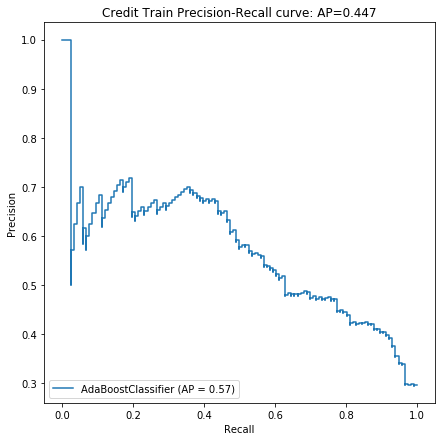

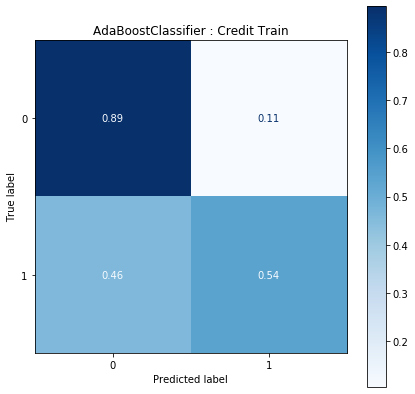

In [91]:
build_cred_precision_recall_curve(cada, cred)
build_confusion_matrix(cada, cred)
predicted_cred = cada.predict(X_cred)
print("Classification report for classifier %s:\n\n%s\n" % (cada, classification_report(y_cred, predicted_cred)))
print_cross_val(cada, cred)

AdaBoostClassifier(algorithm='SAMME.R',
                   base_estimator=DecisionTreeClassifier(ccp_alpha=0.0,
                                                         class_weight=None,
                                                         criterion='gini',
                                                         max_depth=9,
                                                         max_features=None,
                                                         max_leaf_nodes=None,
                                                         min_impurity_decrease=0.0,
                                                         min_impurity_split=None,
                                                         min_samples_leaf=1,
                                                         min_samples_split=2,
                                                         min_weight_fraction_leaf=0.0,
                                                         presort='deprecated',
                          

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed: 73.9min finished


AdaBoostClassifier : MNIST Train
Scores:  [0.961875   0.964375   0.96464286 0.96598214 0.96401786] Avg:  0.9641785714285713


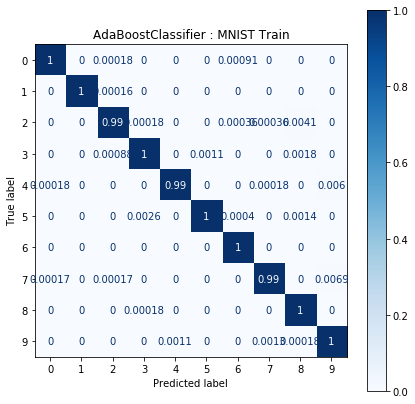

In [71]:
build_confusion_matrix(mada, mnist)
predicted_mnist = mada.predict(X_mnist)
print("Classification report for classifier %s:\n\n%s\n" % (mada, classification_report(y_mnist, predicted_mnist)))
print_cross_val(mada, mnist)

## Final Performance Analysis on TEST Set

AdaBoostClassifier(algorithm='SAMME.R',
                   base_estimator=DecisionTreeClassifier(ccp_alpha=0.0,
                                                         class_weight=None,
                                                         criterion='gini',
                                                         max_depth=1,
                                                         max_features=None,
                                                         max_leaf_nodes=None,
                                                         min_impurity_decrease=0.0,
                                                         min_impurity_split=None,
                                                         min_samples_leaf=1,
                                                         min_samples_split=2,
                                                         min_weight_fraction_leaf=0.0,
                                                         presort='deprecated',
                          

/home/nikola/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


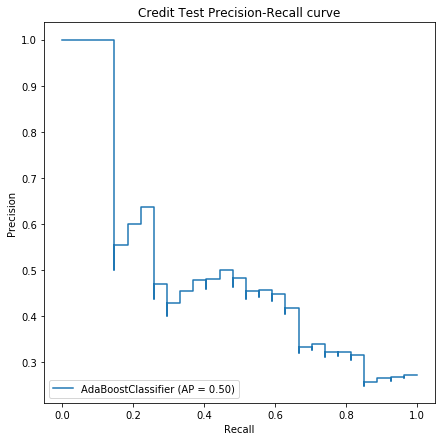

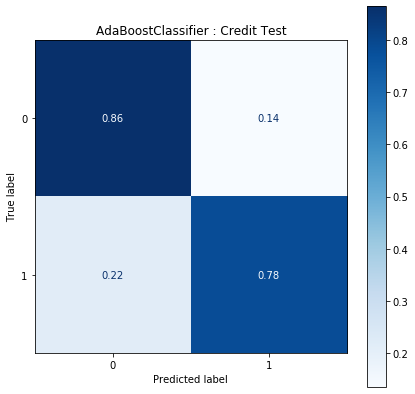

In [99]:
build_cred_precision_recall_curve(cada, cred_test)
build_confusion_matrix(cada, cred_test)
predicted_cred = cada.predict(X_cred_test)
print("Classification report for classifier %s:\n\n%s\n" % (cada, classification_report(y_cred_test, predicted_cred)))

AdaBoostClassifier(algorithm='SAMME.R',
                   base_estimator=DecisionTreeClassifier(ccp_alpha=0.0,
                                                         class_weight=None,
                                                         criterion='gini',
                                                         max_depth=9,
                                                         max_features=None,
                                                         max_leaf_nodes=None,
                                                         min_impurity_decrease=0.0,
                                                         min_impurity_split=None,
                                                         min_samples_leaf=1,
                                                         min_samples_split=2,
                                                         min_weight_fraction_leaf=0.0,
                                                         presort='deprecated',
                          

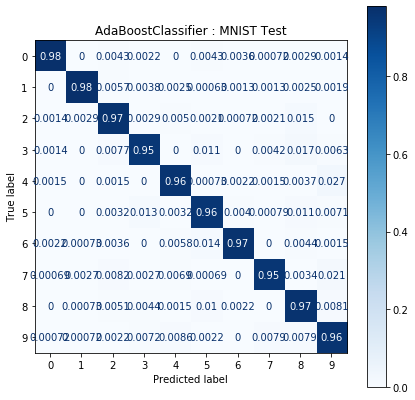

In [102]:
build_confusion_matrix(mada, mnist_test)
predicted_mnist = mada.predict(X_mnist_test)
print("Classification report for classifier %s:\n\n%s\n" % (mada, classification_report(y_mnist_test, predicted_mnist, digits=3)))